In [ ]:
import requests
from astropy.coordinates import SkyCoord
from astropy import units as u
import pandas as pd

# .txt dosyasından RA ve Dec değerlerini oku
input_file = 'input.txt'  # Bu dosya RA ve Dec değerlerini içermelidir
data = pd.read_csv(input_file, delim_whitespace=True, header=None, names=['RA', 'Dec'])

# Vizier URL ve katalog bilgileri
vizier_url = 'http://vizier.u-strasbg.fr/viz-bin/asu-tsv'
catalog = 'I/352/gedr3dis'  # Gaia EDR3 Distances catalog ID

# Sonuçları saklamak için liste
results = []

# Her RA ve Dec değeri için sorgu yap
for index, row in data.iterrows():
    ra = row['RA']
    dec = row['Dec']
    
    # RA ve Dec değerlerini uygun formatta yaz
    coord = SkyCoord(ra, dec, unit=(u.deg, u.deg), frame='icrs')
    ra_str = coord.ra.to_string(unit=u.deg, decimal=True)
    dec_str = coord.dec.to_string(unit=u.deg, decimal=True)

    # Sorgu parametrelerini hazırla
    params = {
        '-source': catalog,
        '-c': f'{ra_str} {dec_str}',
        '-c.eq': 'ICRS',
        '-c.r': '0.01',  # Arama yarıçapı, derece cinsinden
        '-out.add': '_r',
        '-out.max': '1',  # En yakın 1 sonucu al
        '-out': 'Source,RA_ICRS,DE_ICRS,rgeo,b_rgeo,B_rgeo,rpgeo,b_rpgeo,B_rpgeo,Flag'
    }

    # Sorguyu gönder ve sonuçları al
    response = requests.get(vizier_url, params=params)
    if response.status_code == 200:
        result = response.text
        results.append(result)
    else:
        print(f"Sorgu başarısız oldu: RA={ra_str}, Dec={dec_str}")

# Sonuçları bir dosyaya yaz
with open('output.txt', 'w') as output_file:
    for result in results:
        output_file.write(result)

print("Sorgular tamamlandı ve sonuçlar 'output.txt' dosyasına kaydedildi.")


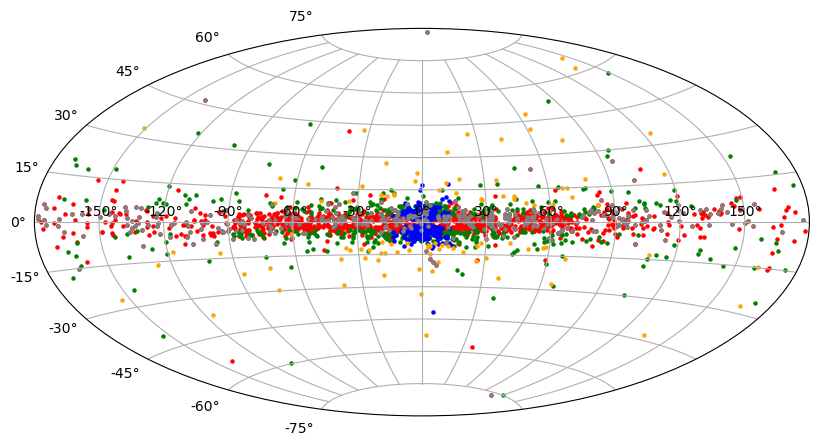

Thin Disc: 1222
Thick Disk: 475
Bulge: 437
no distance: 359
Halo: 98
no distance: 359


In [145]:
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
import numpy as np
import matplotlib.pyplot as plt

# Excel dosyasını yükle
file_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Disc_Region.xlsx'
sheet_name = 'Sayfa1'
new_sheet_name = 'Sayfa2'

# Excel dosyasını oku
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Galactic_RA, Galactic_DEC, Disc_R ve rgeo sütunlarını al
galactic_ra = df['Glon']
galactic_dec = df['Glat']
disc_r = df['Gdist']  # Galaktik merkezden uzaklık sütunu (parsek cinsinden)
rgeo = df['rgeo']  # Kaynakların bizden uzaklıkları (parsek cinsinden)

# Galaktik koordinatları al
l = galactic_ra
b = galactic_dec

# Galaksi merkezini aitoff projeksiyonu üzerinde 0 dereceye 0 derecede konumlandırmak için
l_centered = (l - 180) % 360 - 180  # -180 ile 180 derece arasında merkezlenmiş boylam

# Harita oluştur
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection='aitoff')
ax.grid(True)

# İnce disk ve kalın disk kriterleri (galaktik yükseklik z'de)
z_ince_disk_max = 400  # parsek
z_kalin_disk_max = 1000  # parsek

ince_disk_bolge = np.abs(disc_r) <= z_ince_disk_max
kalin_disk_bolge = (np.abs(disc_r) > z_ince_disk_max) & (np.abs(disc_r) <= z_kalin_disk_max)

# İnce disk bölgesini işaretle
ax.scatter(np.radians(l_centered[ince_disk_bolge]), np.radians(b[ince_disk_bolge]), color='red', s=5)#, label='Thin Disc')

# Kalın disk bölgesini işaretle
ax.scatter(np.radians(l_centered[kalin_disk_bolge]), np.radians(b[kalin_disk_bolge]), color='green', s=5)#, label='Thick Disc')

# Galaksi merkezi ve şişkin bölge tanımı
galactic_center_distance_from_us = 8340  # parsek
galactic_bulge_radius = 2000  # parsek

# Şişkin bölge kriteri: Galaksi merkezi etrafında 2 kpc yarıçapında bir küre
siskin_bolge_bolge = (rgeo >= (galactic_center_distance_from_us - galactic_bulge_radius)) & (rgeo <= (galactic_center_distance_from_us + galactic_bulge_radius))

# Glon değeri 14 ile 346 arasında olanları şişkin bölgeden çıkartma
siskin_bolge_bolge = siskin_bolge_bolge & ~((galactic_ra > 14) & (galactic_ra < 346))

# Şişkin bölge içinde olan noktaları mavi renkte çiz
ax.scatter(np.radians(l_centered[siskin_bolge_bolge]), np.radians(b[siskin_bolge_bolge]), color='blue', s=5)#, label='Galactic Bulge')

# Halo bölgesi
halo_bolge = ~(ince_disk_bolge | kalin_disk_bolge | siskin_bolge_bolge)
ax.scatter(np.radians(l_centered[halo_bolge]), np.radians(b[halo_bolge]), color='orange', s=5)#, label='Halo')

# Diskten uzaklığı 0 olan noktaları gri renkte çiz
ax.scatter(np.radians(l_centered[np.isclose(disc_r, 0)]), np.radians(b[np.isclose(disc_r, 0)]), color='gray', s=5 )#, label='No Distance')

# Eksenleri ve başlığı ekle
#ax.set_title('Galactic Coordinate Map')
#ax.set_xlabel('Galactic Longitude (l) [degree]')
#ax.set_ylabel('Galactic Latitude (b) [degree]')

# PNG dosyasını kaydet
plt.savefig('/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Aitof_project.png')
plt.show()
plt.close()

# Excel dosyasını yükle
wb = load_workbook(file_path)

# Yeni sayfa oluştur
if new_sheet_name in wb.sheetnames:
    ws = wb[new_sheet_name]
else:
    ws = wb.create_sheet(new_sheet_name)

# Gbileşen sütununu oluştur ve verileri güncelle
df['Gbileşen'] = ''
for idx in df.index:
    if np.isclose(disc_r[idx], 0):
        df.at[idx, 'Gbileşen'] = 'no distance'
    elif siskin_bolge_bolge[idx]:
        df.at[idx, 'Gbileşen'] = 'Bulge'
    elif ince_disk_bolge[idx]:
        df.at[idx, 'Gbileşen'] = 'Thin Disc'
    elif kalin_disk_bolge[idx]:
        df.at[idx, 'Gbileşen'] = 'Thick Disk'
    else:
        df.at[idx, 'Gbileşen'] = 'Halo'

# Güncellenen verileri yeni sayfaya yaz
for r in dataframe_to_rows(df, index=False, header=True):
    ws.append(r)

# Şişkin bölgeye denk gelen satırları belirle
for idx in df.index:
    row_num = idx + 2
    gbilesen = df.at[idx, 'Gbileşen']
    
    if gbilesen == 'no distance':
        fill = PatternFill(start_color='C0C0C0', end_color='C0C0C0', fill_type='solid')  # Gri
    elif gbilesen == 'Thin Disc':
        fill = PatternFill(start_color='FF0000', end_color='FF0000', fill_type='solid')  # Kırmızı
    elif gbilesen == 'Thick Disk':
        fill = PatternFill(start_color='00FF00', end_color='00FF00', fill_type='solid')  # Yeşil
    elif gbilesen == 'Bulge':
        fill = PatternFill(start_color='0000FF', end_color='0000FF', fill_type='solid')  # Mavi
    elif gbilesen == 'Halo':
        fill = PatternFill(start_color='FFA500', end_color='FFA500', fill_type='solid')  # Turuncu
    else:
        fill = None
    
    # Renklendirme işlemini ilgili hücrelere uygula
    if fill:
        for col in range(1, len(df.columns) + 1):
            ws.cell(row=row_num, column=col).fill = fill

# Değişiklikleri kaydet
wb.save(file_path)

# Gbileşen sütunundaki her bir kategorinin sayısını hesapla
gbilesen_counts = df['Gbileşen'].value_counts()

# Gbileşen sütunundaki verilerin sayısını ekrana yazdır
for gbilesen, count in gbilesen_counts.items():
    print(f"{gbilesen}: {count}")

# no distance veri sayısını ekrana yazdır
no_distance_count = (df['Gdist'] == 0).sum()
print(f"no distance: {no_distance_count}")

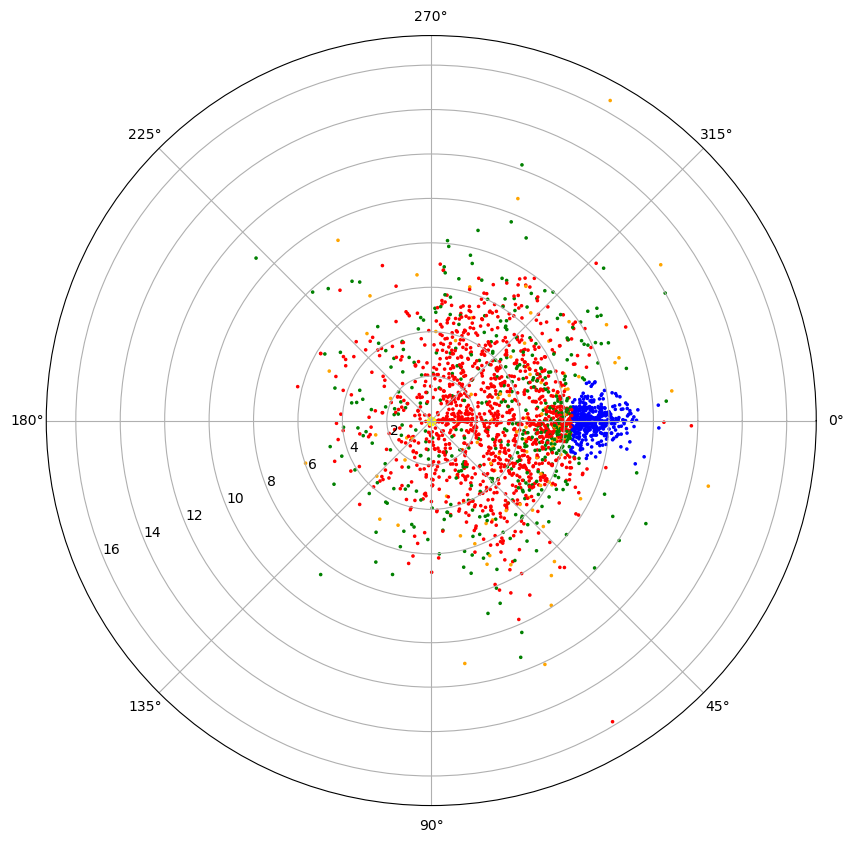

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Excel dosyasını okuma
file_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Disc_Region.xlsx'
sheet_name = 'Sayfa2'

# Excel dosyasını yükleyin
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Longitude, latitude ve uzaklık verilerini alın
glon = pd.to_numeric(df['Glon'], errors='coerce')
glat = pd.to_numeric(df['Glat'], errors='coerce')
rgeo = pd.to_numeric(df['rgeo'], errors='coerce') / 1000  # parsec'leri kiloparsec'e çevirin
gbilesen = df['Gbileşen']

# Geçersiz verileri çıkarın
valid_indices = ~np.isnan(glon) & ~np.isnan(glat) & ~np.isnan(rgeo)
glon = glon[valid_indices]
glat = glat[valid_indices]
rgeo = rgeo[valid_indices]
gbilesen = gbilesen[valid_indices]

# Renk haritası oluşturma
color_map = {
    'Bulge': 'blue',
    'Thin Disc': 'red',
    'Thick Disk': 'green',
    'Halo': 'orange',
    'no distance': 'gray'
}
colors = [color_map.get(comp, 'gray') for comp in gbilesen]

# Grafik oluşturma
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 10))
ax.set_theta_zero_location('E')
ax.set_theta_direction(-1)

# H II bölgelerinin yerlerini renklendirerek gösterme
ax.scatter(np.radians(glon), rgeo, marker='.', s=10, color=colors)

# Güneş'in konumu
ax.scatter(0, 0, marker='o', color='yellow')

# Çemberler üzerindeki uzaklıkların kpc cinsinden gösterilmesi
r_ticks = np.arange(2, 18, 2)
ax.set_rticks(r_ticks)
ax.set_rlabel_position(157.5)

# Başlık ve etiketler
#ax.set_title('Spatial Distribution of PN Regions', va='bottom')

# Grafiği kaydetmek için dosya yolu oluşturma
klasor_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/"
dosya_adi = "PN_Regions_Spatial_Distribution.png"
kaydet_yolu = os.path.join(klasor_yolu, dosya_adi)

# Grafiği kaydet
plt.savefig(kaydet_yolu, dpi=300)

plt.show()


Bulge için bin sayıları: [  0.   0.   0.   0.   0.   0. 181. 180.  66.   8.   2.   0.   0.   0.
   0.   0.   0.]
Thin Disc için bin sayıları: [ 63. 160. 168. 206. 220. 245. 109.  38.   6.   3.   2.   1.   0.   0.
   0.   1.   0.]
Thick Disk için bin sayıları: [  6.  28.  34.  56.  78. 136.  77.  30.  13.   8.   6.   2.   1.   0.
   0.   0.   0.]
Halo için bin sayıları: [ 0.  4.  7. 12. 12. 26. 19.  4.  5.  2.  2.  1.  3.  0.  0.  0.  1.]


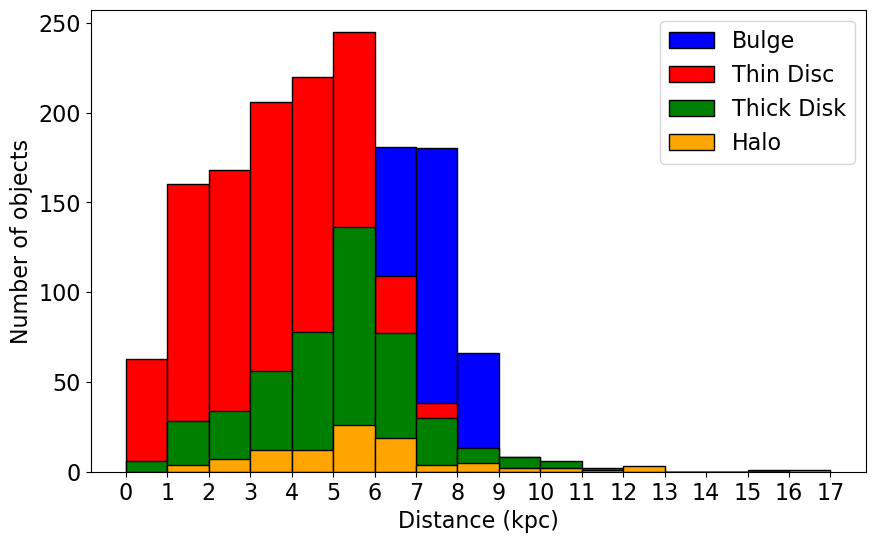

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from openpyxl import load_workbook

# Excel dosyasını oku
excel_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Disc_Region.xlsx"
renklendirilmis_df = pd.read_excel(excel_yolu, sheet_name='Sayfa2')

# Kullanılacak sütunları seç
rgeo_sutunu = renklendirilmis_df['rgeo']
gbilesen_sutunu = renklendirilmis_df['Gbileşen']

# Verileri sayısal değerlere dönüştür
rgeo_sutunu = pd.to_numeric(rgeo_sutunu, errors='coerce')

# Verileri pc biriminden kpc birimine dönüştür
rgeo_sutunu_kpc = rgeo_sutunu / 1000

# Renklerin ve etiketlerin belirlenmesi
renk_etiketleri = {
    'Bulge': 'blue',          # Bulge ise mavi
    'Thin Disc': 'red',       # Thin Disc ise kırmızı
    'Thick Disk': 'green',    # Thick Disk ise yeşil
    'Halo': 'orange',         # Halo ise turuncu
    #'No Distance': 'gray'     # no distance ise gri
}

bins = np.arange(0, 18, 1)

# Tek bir histogram üzerinde tüm bileşenleri çiz
plt.figure(figsize=(10, 6))

for component, color in renk_etiketleri.items():
    component_values = rgeo_sutunu_kpc[gbilesen_sutunu == component]
    counts, bins, patches = plt.hist(component_values, bins=bins, label=component, color=color, edgecolor='black')
    print(f"{component} için bin sayıları: {counts}")

plt.xticks(bins)
plt.xlabel('Distance (kpc)')
plt.ylabel('Number of objects')
plt.legend(title='')

# Grafik dosyası yolunu belirle
save_path = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Gaia_Distance.png"
plt.savefig(save_path)

# Grafiği göster
plt.show()

Bulge için bin sayıları: [  0.   0.   0.   0.   0.   0. 181. 180.  66.   8.   2.   0.   0.   0.
   0.   0.   0.]
Thin Disc için bin sayıları: [ 63. 160. 168. 206. 220. 245. 109.  38.   6.   3.   2.   1.   0.   0.
   0.   1.   0.]
Thick Disc için bin sayıları: [  6.  28.  34.  56.  78. 136.  77.  30.  13.   8.   6.   2.   1.   0.
   0.   0.   0.]
Halo için bin sayıları: [ 0.  4.  7. 12. 12. 26. 19.  4.  5.  2.  2.  1.  3.  0.  0.  0.  1.]


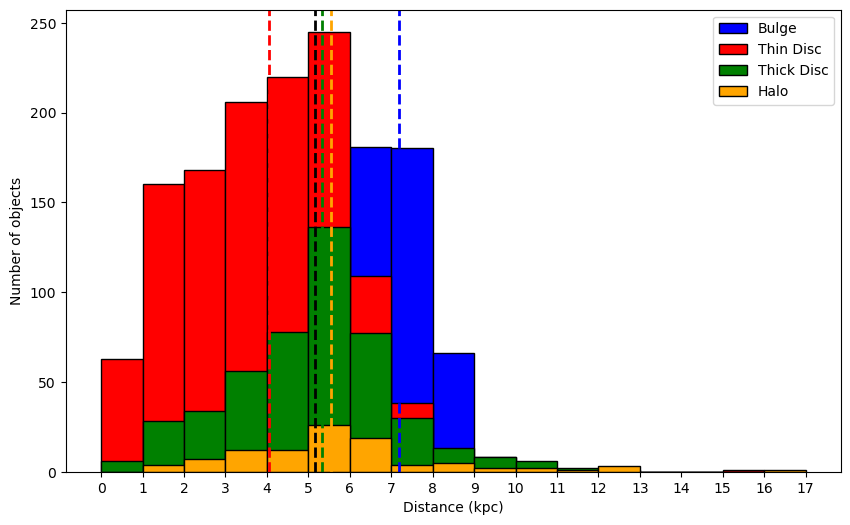

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Excel dosyasını oku
excel_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Disc_Region.xlsx"
renklendirilmis_df = pd.read_excel(excel_yolu, sheet_name='Sayfa2')

# Kullanılacak sütunları seç
rgeo_sutunu = renklendirilmis_df['rgeo']
gbilesen_sutunu = renklendirilmis_df['Gbileşen']

# Verileri sayısal değerlere dönüştür
rgeo_sutunu = pd.to_numeric(rgeo_sutunu, errors='coerce')

# Verileri pc biriminden kpc birimine dönüştür
rgeo_sutunu_kpc = rgeo_sutunu / 1000

# Renklerin ve etiketlerin belirlenmesi
renk_etiketleri = {
    'Bulge': 'blue',          # Bulge ise mavi
    'Thin Disc': 'red',       # Thin Disc ise kırmızı
    'Thick Disc': 'green',    # Thick Disk ise yeşil
    'Halo': 'orange',         # Halo ise turuncu
    #'No Distance': 'gray'     # no distance ise gri
}

bins = np.arange(0, 18, 1)

# Tek bir histogram üzerinde tüm bileşenleri çiz
plt.figure(figsize=(10, 6))

# Her bileşenin medyanını hesapla ve histogramı çiz
for component, color in renk_etiketleri.items():
    component_values = rgeo_sutunu_kpc[gbilesen_sutunu == component]
    counts, bins, patches = plt.hist(component_values, bins=bins, label=component, color=color, edgecolor='black')
    print(f"{component} için bin sayıları: {counts}")
    
    # Her bileşenin medyan değerini hesapla ve kesikli çizgi çiz
    median_value = np.median(component_values.dropna())  # NaN değerlerini çıkartıyoruz
    plt.axvline(median_value, color=color, linestyle='--', linewidth=2)

# Tüm verinin medyanını hesapla ve siyah kesikli çizgi çiz
genel_median = np.median(rgeo_sutunu_kpc.dropna())
plt.axvline(genel_median, color='black', linestyle='--', linewidth=2)

plt.xticks(bins)
plt.xlabel('Distance (kpc)')
plt.ylabel('Number of objects')
plt.legend(title='')

# Grafik dosyası yolunu belirle
save_path = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Gaia_Distance.png"
plt.savefig(save_path)

# Grafiği göster
plt.show()


In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Excel dosyasını oku
excel_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Disc_Region.xlsx"
neat_result_df = pd.read_excel(excel_yolu, sheet_name='neat_result')
renklendirilmis_df = pd.read_excel(excel_yolu, sheet_name='Sayfa2')

# Histogramlar için klasör oluştur
klasor_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/histogramlar/ort/"
if not os.path.exists(klasor_yolu):
    os.makedirs(klasor_yolu)

# Ortalamalar için dosya oluştur
ortalama_dosyasi_yolu = os.path.join(klasor_yolu, "ortalama_degerler.txt")

# Renklendirme fonksiyonu
def get_color(component):
    if component == 'Bulge':
        return 'blue'
    elif component == 'Thin Disc':
        return 'red'
    elif component == 'Thick Disk':
        return 'green'
    elif component == 'Halo':
        return 'orange'
    else:
        return None

# Renklendirme bilgilerini ekle
renklendirilmis_df['color'] = renklendirilmis_df['Gbileşen'].apply(get_color)
renk_dict = renklendirilmis_df.set_index('idPNMain')['color'].to_dict()

# Sütun başlıkları
sutun_basliklari = ['c(Hb) (Ha/Hb)', 'c(Hb) (Hg/Hb)', 'c(Hb) (Hd/Hb)', '[OII] density', '[SII] Density', '[ArIV] density', 
                    '[OII] temperature', '[SII] temperature', '[NII] temperature', 
                    '[OI] temperature', '[OIII] Temperature', '[NeIII] temperature', 
                    '[ArIII] temperature', '[ArV] temperature', 'He I temperature (7281/6678)', 
                    'C/H', 'N/H', 'O/H', 'Ne/H', 'Ar/H', 'S/H', 'Cl/H', 'He/H']

# Histogram parametreleri
histogram_parametreleri = {
    'c(Hb) (Ha/Hb)': {'bins': 50, 'range': (0, 6)},
    'c(Hb) (Hg/Hb)': {'bins': 50, 'range': (0, 6)},
    'c(Hb) (Hd/Hb)': {'bins': 50, 'range': (0, 6)},
    '[OII] density': {'bins': 50, 'range': (0, 20000)},
    '[SII] Density': {'bins': 50, 'range': (0, 15000)},
    '[ArIV] density': {'bins': 50, 'range': (0, 70000)},
    '[OII] temperature': {'bins': 50, 'range': (5000, 35000)},
    '[SII] temperature': {'bins': 50, 'range': (0, 35000)},
    '[NII] temperature': {'bins': 100, 'range': (5000, 35000)},
    '[OI] temperature': {'bins': 50, 'range': (0, 35000)},
    '[OIII] Temperature': {'bins': 50, 'range': (5000, 35000)},
    '[NeIII] temperature': {'bins': 50, 'range': (0, 35000)},
    '[ArIII] temperature': {'bins': 50, 'range': (5000, 35000)},
    '[ArV] temperature': {'bins': 50, 'range': (0, 35000)},
    'He I temperature (7281/6678)': {'bins': 50, 'range': (0, 4e5)},
    'C/H': {'bins': 50, 'range': (0, 1e-3)},
    'N/H': {'bins': 50, 'range': (0, 1e-3)},
    'O/H': {'bins': 50, 'range': (0, 3e-3)},
    'Ne/H': {'bins': 50, 'range': (0, 3e-3)},
    'Ar/H': {'bins': 50, 'range': (0, 175e-7)},
    'S/H': {'bins': 50, 'range': (0, 3e-5)},
    'Cl/H': {'bins': 50, 'range': (0, 0.6e-5)},
    'He/H': {'bins': 50, 'range': (0, 0.5)}
}

# Renklere karşılık gelen etiketler
renk_etiketleri = {
    'red': 'Thin Disc',
    'green': 'Thick Disc',
    'blue': 'Bulge',
    'orange': 'Halo'
}

# Ortalamaları yazmak için dosyayı aç
with open(ortalama_dosyasi_yolu, 'w') as f:
    # Her sütun için histogram oluştur
    for baslik in sutun_basliklari:
        plt.figure()
        bins = histogram_parametreleri[baslik]['bins']
        range_ = histogram_parametreleri[baslik]['range']
        ortalamalar = {}
        
        # 0 değerleri hariç tutarak tüm verilerin ortalamasını hesapla ve siyah kesikli çizgi olarak göster
        tum_veriler_ortalama = neat_result_df[baslik][neat_result_df[baslik] != 0].mean()
        plt.axvline(tum_veriler_ortalama, color='black', linestyle='dashed', linewidth=1)
        print(f"{baslik} - Tüm Veriler Ortalaması (0 hariç): {tum_veriler_ortalama:.2e}")
        f.write(f"{baslik} - Tüm Veriler Ortalaması (0 hariç): {tum_veriler_ortalama:.2e}\n")
        
        for color, etiket in renk_etiketleri.items():
            filtreli_veri = neat_result_df[neat_result_df['idPNMain'].map(renk_dict) == color][baslik]
            filtreli_veri = filtreli_veri[(filtreli_veri != 0) & (filtreli_veri != 35000)]
            
            if not filtreli_veri.empty:
                plt.hist(filtreli_veri, bins=bins, range=range_, edgecolor='black', color=color, label=etiket)
                ortalama = filtreli_veri.mean()
                ortalamalar[etiket] = ortalama
        
        # Ortalama değerleri kesikli çizgilerle göster
        for etiket, ortalama in ortalamalar.items():
            color = [k for k, v in renk_etiketleri.items() if v == etiket][0]
            plt.axvline(ortalama, color=color, linestyle='dashed', linewidth=1)
            print(f"{baslik} - {etiket} Ortalama (0 hariç): {ortalama:.2e}")
            f.write(f"{baslik} - {etiket} Ortalama (0 hariç): {ortalama:.2e}\n")
        
        # Plot ayarları
        if baslik in ['c(Hb) (Ha/Hb)', 'c(Hb) (Hg/Hb)', 'c(Hb) (Hd/Hb)']:
            plt.xlabel("cH(β)")
        else:
            plt.xlabel(baslik)
        
        plt.ylabel("Number")
        plt.legend(fontsize=12)
        
        # Histogramı kaydet
        kaydet_yolu = os.path.join(klasor_yolu, f"{baslik.replace('/', '_')}.png")
        plt.savefig(kaydet_yolu, dpi=300)
        
        # Plot'u temizle
        plt.clf()

print("Histogramlar başarıyla oluşturuldu ve ortalamalar listeye yazıldı.")


c(Hb) (Ha/Hb) - Tüm Veriler Ortalaması (0 hariç): 1.48e+00
c(Hb) (Ha/Hb) - Thin Disc Ortalama (0 hariç): 1.66e+00
c(Hb) (Ha/Hb) - Thick Disc Ortalama (0 hariç): 1.06e+00
c(Hb) (Ha/Hb) - Bulge Ortalama (0 hariç): 1.72e+00
c(Hb) (Ha/Hb) - Halo Ortalama (0 hariç): 5.38e-01
c(Hb) (Hg/Hb) - Tüm Veriler Ortalaması (0 hariç): 3.27e+00
c(Hb) (Hg/Hb) - Thin Disc Ortalama (0 hariç): 3.26e+00
c(Hb) (Hg/Hb) - Thick Disc Ortalama (0 hariç): 2.42e+00
c(Hb) (Hg/Hb) - Bulge Ortalama (0 hariç): 3.59e+00
c(Hb) (Hg/Hb) - Halo Ortalama (0 hariç): 2.46e+00
c(Hb) (Hd/Hb) - Tüm Veriler Ortalaması (0 hariç): 1.67e+00
c(Hb) (Hd/Hb) - Thin Disc Ortalama (0 hariç): 1.68e+00
c(Hb) (Hd/Hb) - Thick Disc Ortalama (0 hariç): 1.33e+00
c(Hb) (Hd/Hb) - Bulge Ortalama (0 hariç): 2.23e+00
c(Hb) (Hd/Hb) - Halo Ortalama (0 hariç): 1.20e+00
[OII] density - Tüm Veriler Ortalaması (0 hariç): 1.04e+04
[OII] density - Thin Disc Ortalama (0 hariç): 1.15e+04
[OII] density - Thick Disc Ortalama (0 hariç): 6.24e+03
[OII] density - B

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[SII] temperature - Tüm Veriler Ortalaması (0 hariç): nan
[NII] temperature - Tüm Veriler Ortalaması (0 hariç): 1.65e+04
[NII] temperature - Thin Disc Ortalama (0 hariç): 1.23e+04
[NII] temperature - Thick Disc Ortalama (0 hariç): 1.28e+04
[NII] temperature - Bulge Ortalama (0 hariç): 1.17e+04
[NII] temperature - Halo Ortalama (0 hariç): 1.27e+04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[OI] temperature - Tüm Veriler Ortalaması (0 hariç): nan
[OIII] Temperature - Tüm Veriler Ortalaması (0 hariç): 1.49e+04
[OIII] Temperature - Thin Disc Ortalama (0 hariç): 1.23e+04
[OIII] Temperature - Thick Disc Ortalama (0 hariç): 1.22e+04
[OIII] Temperature - Bulge Ortalama (0 hariç): 1.31e+04
[OIII] Temperature - Halo Ortalama (0 hariç): 1.13e+04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[NeIII] temperature - Tüm Veriler Ortalaması (0 hariç): nan
[ArIII] temperature - Tüm Veriler Ortalaması (0 hariç): 2.86e+04
[ArIII] temperature - Thin Disc Ortalama (0 hariç): 1.62e+04
[ArIII] temperature - Thick Disc Ortalama (0 hariç): 1.59e+04
[ArIII] temperature - Bulge Ortalama (0 hariç): 1.86e+04
[ArIII] temperature - Halo Ortalama (0 hariç): 1.60e+04


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[ArV] temperature - Tüm Veriler Ortalaması (0 hariç): nan
He I temperature (7281/6678) - Tüm Veriler Ortalaması (0 hariç): 1.61e+10
He I temperature (7281/6678) - Thin Disc Ortalama (0 hariç): 2.50e+10
He I temperature (7281/6678) - Thick Disc Ortalama (0 hariç): 1.92e+10
He I temperature (7281/6678) - Bulge Ortalama (0 hariç): 4.86e+07
He I temperature (7281/6678) - Halo Ortalama (0 hariç): 2.55e+08


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


C/H - Tüm Veriler Ortalaması (0 hariç): nan
N/H - Tüm Veriler Ortalaması (0 hariç): 3.21e-04
N/H - Thin Disc Ortalama (0 hariç): 3.84e-04
N/H - Thick Disc Ortalama (0 hariç): 2.02e-04
N/H - Bulge Ortalama (0 hariç): 3.04e-04
N/H - Halo Ortalama (0 hariç): 8.60e-05
O/H - Tüm Veriler Ortalaması (0 hariç): 1.55e-03
O/H - Thin Disc Ortalama (0 hariç): 1.84e-03
O/H - Thick Disc Ortalama (0 hariç): 1.15e-03
O/H - Bulge Ortalama (0 hariç): 9.70e-04
O/H - Halo Ortalama (0 hariç): 1.37e-03
Ne/H - Tüm Veriler Ortalaması (0 hariç): 1.28e-03
Ne/H - Thin Disc Ortalama (0 hariç): 1.93e-03
Ne/H - Thick Disc Ortalama (0 hariç): 2.88e-04
Ne/H - Bulge Ortalama (0 hariç): 1.69e-04
Ne/H - Halo Ortalama (0 hariç): 1.68e-03
Ar/H - Tüm Veriler Ortalaması (0 hariç): 1.38e-05
Ar/H - Thin Disc Ortalama (0 hariç): 1.69e-05
Ar/H - Thick Disc Ortalama (0 hariç): 9.62e-06
Ar/H - Bulge Ortalama (0 hariç): 1.11e-05
Ar/H - Halo Ortalama (0 hariç): 3.59e-06


/var/folders/ry/6rcrw5vs4f33lx3wyt4f6m5w0000gn/T/ipykernel_2077/2282621326.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


S/H - Tüm Veriler Ortalaması (0 hariç): 1.45e-05
S/H - Thin Disc Ortalama (0 hariç): 1.70e-05
S/H - Thick Disc Ortalama (0 hariç): 8.55e-06
S/H - Bulge Ortalama (0 hariç): 1.33e-05
S/H - Halo Ortalama (0 hariç): 5.78e-06
Cl/H - Tüm Veriler Ortalaması (0 hariç): 3.34e-06
Cl/H - Thin Disc Ortalama (0 hariç): 3.93e-06
Cl/H - Thick Disc Ortalama (0 hariç): 2.58e-06
Cl/H - Bulge Ortalama (0 hariç): 1.63e-06
Cl/H - Halo Ortalama (0 hariç): 3.67e-06
He/H - Tüm Veriler Ortalaması (0 hariç): 3.31e-01
He/H - Thin Disc Ortalama (0 hariç): 3.44e-01
He/H - Thick Disc Ortalama (0 hariç): 2.99e-01
He/H - Bulge Ortalama (0 hariç): 3.21e-01
He/H - Halo Ortalama (0 hariç): 3.07e-01
Histogramlar başarıyla oluşturuldu ve ortalamalar listeye yazıldı.


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
####### NEAT SONUÇLARINDA ORTALAMALARI TABLOLAŞTIRMA ##########


import os

# Ortalamalar dosyasını oku
ortalama_dosyasi_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/histogramlar/ortalama_degerler.txt"
with open(ortalama_dosyasi_yolu, 'r') as f:
    ortalama_veriler = f.readlines()

# Ortalamaları bir sözlükte sakla
ortalama_dict = {}
bilesenler = set()
for veri in ortalama_veriler:
    veri = veri.strip()
    baslik, kalan = veri.split(' - ')
    bilesen, ortalama = kalan.split(' Ortalama: ')
    if baslik not in ortalama_dict:
        ortalama_dict[baslik] = {}
    ortalama_dict[baslik][bilesen] = ortalama
    bilesenler.add(bilesen)

# LaTeX formatında tabloyu oluştur
latex_tablo = """
\\begin{table}[H]
\\centering
\\begin{tabular}{|c|""" + 'c|' * len(bilesenler) + """}
\\hline
Sütun Başlığı & """ + ' & '.join(bilesenler) + """ \\\\
\\hline
"""

for baslik, bilesen_dict in ortalama_dict.items():
    row = baslik
    for bilesen in bilesenler:
        row += ' & ' + bilesen_dict.get(bilesen, '')
    latex_tablo += row + " \\\\\n\\hline\n"

latex_tablo += """
\\end{tabular}
\\caption{Ortalama Değerler}
\\label{tab:ortalama_degerler}
\\end{table}
"""

# LaTeX tabloyu dosyaya yaz
latex_tablo_dosyasi_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/histogramlar/ortalama_degerler_tablo.tex"
with open(latex_tablo_dosyasi_yolu, 'w') as f:
    f.write(latex_tablo)

print("LaTeX tablosu başarıyla oluşturuldu ve kaydedildi.")


LaTeX tablosu başarıyla oluşturuldu ve kaydedildi.


In [11]:
from astropy.io import fits
import pandas as pd
import os

# Dizin içindeki tüm FITS dosyalarını al
fits_directory = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/neat_out/'
fits_file_paths = [os.path.join(fits_directory, file) for file in sorted(os.listdir(fits_directory)) if file.endswith('.fits')]

# Excel dosyalarının kaydedileceği dizin
output_directory = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/'
os.makedirs(output_directory, exist_ok=True)

# Her 50 FITS dosyası için ayrı bir Excel dosyası oluştur
batch_size = 50

# Dosya isimlerini saklayacak bir sözlük oluştur
file_names_dict = {}

for i in range(0, len(fits_file_paths), batch_size):
    batch_fits_files = fits_file_paths[i:i + batch_size]

    # Excel dosyasının ismini belirle
    excel_file_name = f'batch_{i // batch_size + 1}.xlsx'
    excel_file_path = os.path.join(output_directory, excel_file_name)

    # Her FITS dosyası için döngü
    with pd.ExcelWriter(excel_file_path, engine='openpyxl') as writer:
        for fits_file_path in batch_fits_files:
            # Open the FITS file
            with fits.open(fits_file_path) as hdul:
                # Access the data and header of the LINES BinTableHDU (hdul[2])
                data = hdul[1].data

                # Convert the FITS data to a pandas DataFrame
                df = pd.DataFrame(data)

                # Sadece belirtilen sütunları seç
                selected_columns = ['WlenRest', 'Flux', 'Uncertainty', 'Ion', 'DereddenedFlux', 'DereddenedFluxLo', 'DereddenedFluxHi']
                df_selected = df[selected_columns]

                # Negatif ve sıfıra eşit olan değerlere sahip satırları filtrele ve sil
                df_selected = df_selected[df_selected['Flux'] > 0.01]

                # Sayfa adını dosya isminin ilk 31 karakteri olarak ayarla
                sheet_name = os.path.basename(fits_file_path)[:31]
                
                # Tam dosya ismini sözlüğe ekle
                file_names_dict[sheet_name] = os.path.basename(fits_file_path)

                # Verileri içeren DataFrame'i yeni bir sayfada kaydet
                df_selected.to_excel(writer, sheet_name=sheet_name, index=False)

    print(f"Data has been successfully exported to {excel_file_path}")

# Dosya isimlerini bir CSV dosyasına kaydedelim
file_names_dict_path = os.path.join(output_directory, 'file_names_dict.csv')
file_names_df = pd.DataFrame(list(file_names_dict.items()), columns=['SheetName', 'FullFileName'])
file_names_df.to_csv(file_names_dict_path, index=False)

Data has been successfully exported to /Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/batch_1.xlsx
Data has been successfully exported to /Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/batch_2.xlsx
Data has been successfully exported to /Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/batch_3.xlsx
Data has been successfully exported to /Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/batch_4.xlsx
Data has been successfully exported to /Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/batch_5.xlsx
Data has been successfully exported to /Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/batch_6.xlsx
Data has been successfully exported to /Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/batch_7.xlsx
Data has been successfully exported to /Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/batch_8.xlsx
Data has

In [21]:
import pandas as pd
import os

# Excel dosyalarının bulunduğu klasörün tam yolu
excel_folder_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/batch/'

# Tüm Excel dosyalarını al
excel_files = [os.path.join(excel_folder_path, file) for file in sorted(os.listdir(excel_folder_path)) if file.endswith('.xlsx')]

# Dosya isimleri sözlüğünü oku
file_names_dict_path = os.path.join(excel_folder_path, 'file_names_dict.csv')
file_names_df = pd.read_csv(file_names_dict_path)
file_names_dict = dict(zip(file_names_df['SheetName'], file_names_df['FullFileName']))

# Birleştirilecek verileri tutacak ana DataFrame'i oluştur
main_df = pd.DataFrame()

# Her Excel dosyası için döngü
for excel_file_path in excel_files:
    # Excel dosyasını oku
    df = pd.read_excel(excel_file_path, sheet_name=None)

    # Her sayfa için döngü
    for sheet_name, sheet_data in df.items():
        # 'WlenRest', 'Ion', 'Flux' sütunlarını içeren sayfaları seç
        if all(col in sheet_data.columns for col in ['WlenRest', 'Ion', 'Flux']):
            full_file_name = file_names_dict.get(sheet_name, sheet_name)
            # Eğer ana DataFrame boşsa, direkt ekle
            if main_df.empty:
                main_df = sheet_data[['WlenRest', 'Ion', 'Flux']].copy()
                main_df.rename(columns={'Flux': f'{full_file_name}'}, inplace=True)
            else:
                # Ana DataFrame'de 'WlenRest' ve 'Ion' sütunlarına göre birleştirme yap
                main_df = main_df.merge(sheet_data[['WlenRest', 'Ion', 'Flux']],
                                        on=['WlenRest', 'Ion'],
                                        how='outer',
                                        suffixes=('', f'_{full_file_name}'))

# NaN değerleri '-' ile değiştir
main_df.fillna('-', inplace=True)

# 'WlenRest' sütununa göre küçükten büyüğe sırala
main_df.sort_values('WlenRest', inplace=True)

# Excel dosyasına ekleyeceğimiz sayfa adı
new_sheet_name = 'Flux_Tablo'

# Yeni bir Excel dosyası oluştur
output_excel_file_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Fluxtablo.xlsx'
with pd.ExcelWriter(output_excel_file_path, engine='openpyxl') as writer:
    main_df.to_excel(writer, sheet_name=new_sheet_name, index=False)

print(f"Merged, sorted data has been successfully added to the sheet {new_sheet_name} in the Excel file.")

/var/folders/ry/6rcrw5vs4f33lx3wyt4f6m5w0000gn/T/ipykernel_73226/3376182227.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  main_df.fillna('-', inplace=True)


Merged, sorted data has been successfully added to the sheet Flux_Tablo in the Excel file.


In [23]:
import pandas as pd
import os

# Excel dosyalarının bulunduğu klasörün tam yolu
excel_folder_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/batch/'

# Tüm Excel dosyalarını al
excel_files = [os.path.join(excel_folder_path, file) for file in sorted(os.listdir(excel_folder_path)) if file.endswith('.xlsx')]

# Dosya isimleri sözlüğünü oku
file_names_dict_path = os.path.join(excel_folder_path, 'file_names_dict.csv')
file_names_df = pd.read_csv(file_names_dict_path)
file_names_dict = dict(zip(file_names_df['SheetName'], file_names_df['FullFileName']))

# Birleştirilecek verileri tutacak ana DataFrame'i oluştur
main_df = pd.DataFrame()

# Her Excel dosyası için döngü
for excel_file_path in excel_files:
    # Excel dosyasını oku
    df = pd.read_excel(excel_file_path, sheet_name=None)

    # Her sayfa için döngü
    for sheet_name, sheet_data in df.items():
        # 'WlenRest', 'Ion', 'DereddenedFlux' sütunlarını içeren sayfaları seç
        if all(col in sheet_data.columns for col in ['WlenRest', 'Ion', 'DereddenedFlux']):
            full_file_name = file_names_dict.get(sheet_name, sheet_name)
            # Eğer ana DataFrame boşsa, direkt ekle
            if main_df.empty:
                main_df = sheet_data[['WlenRest', 'Ion', 'DereddenedFlux']].copy()
                main_df.rename(columns={'DereddenedFlux': f'{full_file_name}'}, inplace=True)
            else:
                # Ana DataFrame'de 'WlenRest' ve 'Ion' sütunlarına göre birleştirme yap
                main_df = main_df.merge(sheet_data[['WlenRest', 'Ion', 'DereddenedFlux']],
                                        on=['WlenRest', 'Ion'],
                                        how='outer',
                                        suffixes=('', f'_{full_file_name}'))

# NaN değerleri '-' ile değiştir
main_df.fillna('-', inplace=True)

# 'WlenRest' sütununa göre küçükten büyüğe sırala
main_df.sort_values('WlenRest', inplace=True)

# Excel dosyasına ekleyeceğimiz sayfa adı
new_sheet_name = 'DereddenedFlux_Tablo'

# Yeni bir Excel dosyası oluştur
output_excel_file_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/DereddenedFluxtablo.xlsx'
with pd.ExcelWriter(output_excel_file_path, engine='openpyxl') as writer:
    main_df.to_excel(writer, sheet_name=new_sheet_name, index=False)

print(f"Merged, sorted data has been successfully added to the sheet {new_sheet_name} in the Excel file.")


/var/folders/ry/6rcrw5vs4f33lx3wyt4f6m5w0000gn/T/ipykernel_73226/5250544.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  main_df.fillna('-', inplace=True)


Merged, sorted data has been successfully added to the sheet DereddenedFlux_Tablo in the Excel file.


In [24]:
import os
import pandas as pd
from astropy.io import fits

# Klasördeki tüm FITS dosyalarını al
fits_folder_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/neat_out/'
fits_files = [file for file in os.listdir(fits_folder_path) if file.endswith('.fits')]

# Boş bir DataFrame oluştur
final_data = pd.DataFrame()

# Her bir FITS dosyasını işle
for fits_file in fits_files:
    fits_path = os.path.join(fits_folder_path, fits_file)

    with fits.open(fits_path) as hdul:
        # İlgili HDU'ya eriş
        results_hdu = hdul['RESULTS']
        
        # İlgilenilen sütunu seç (2. sütun, Python'da indeks 1'e denk gelir)
        selected_data = results_hdu.data.field(1)
        
        # Pandas Series'e dönüştür
        fits_data = pd.Series(selected_data, name=fits_file)
        
        # DataFrame'e ekle
        final_data = pd.concat([final_data, fits_data], axis=1)

# Verileri Excel dosyasına yaz
excel_output_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/P_C_Conditions.xlsx'
final_data.to_excel(excel_output_path, index=False)

print(f"Data from FITS files has been successfully saved to {excel_output_path}.")

Data from FITS files has been successfully saved to /Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/P_C_Conditions.xlsx.


In [25]:
################# idPNMain ve fits_name verilerinden smb_bpt verilerini bileşenlerini belirleme ##########


import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

# Excel dosyasını oku
file_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Disc_Region.xlsx'
xls = pd.ExcelFile(file_path)

# Sayfa2 ve Sayfa3 verilerini al
sayfa2_df = pd.read_excel(xls, 'Sayfa2')
sayfa3_df = pd.read_excel(xls, 'smb_bpt')

# Sayfa2'deki Fits_Name sütunundaki verilerin sonundaki boşlukları kaldır
sayfa2_df['Fits_Name'] = sayfa2_df['Fits_Name'].str.strip()

# Verileri Fits_Name sütunu üzerinden birleştir
merged_df = pd.merge(sayfa3_df, sayfa2_df[['Fits_Name', 'Gbileşen']], how='left', on='Fits_Name')

# Renklendirme için bir fonksiyon tanımla
def get_fill_color(gbileşen):
    color_dict = {
        'Bulge': '0000FF',        # Mavi
        'Thin Disc': 'FF0000',    # Kırmızı
        'Thick Disk': '008000',   # Yeşil
        'Halo': 'FFA500',         # Turuncu
        'no distance': '808080',  # Gri
        'no data': '000000'       # Siyah
    }
    return PatternFill(start_color=color_dict.get(gbileşen, 'FFFFFF'), end_color=color_dict.get(gbileşen, 'FFFFFF'), fill_type="solid")

# Renklendirme işlemini uygula ve Gbileşen sütununa veri ekle
wb = load_workbook(file_path)
ws = wb['smb_bpt']

# 'Gbileşen' sütunu var mı kontrol et, yoksa ekle
if 'Gbileşen' not in [cell.value for cell in ws[1]]:
    ws.cell(row=1, column=ws.max_column + 1).value = 'Gbileşen'

# Gbileşen sütununun indeksini al
gbileşen_column_index = [cell.value for cell in ws[1]].index('Gbileşen') + 1

for index, row in merged_df.iterrows():
    if pd.isna(row['Gbileşen']):
        gbileşen_value = 'no data'
    else:
        gbileşen_value = row['Gbileşen']
    
    fill = get_fill_color(gbileşen_value)
    
    ws.cell(row=index+2, column=gbileşen_column_index).value = gbileşen_value  # Gbileşen verisini ekle
    for cell in ws[index+2]:  # Excel'de indeksler 1'den başlar ve başlık satırını atlamalıyız
        cell.fill = fill

# Sonuçları yeni bir dosyaya kaydet
output_file_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/smb_bpt.xlsx'
wb.save(output_file_path)

print(f"Renklendirilmiş dosya '{output_file_path}' konumuna kaydedildi.")

Renklendirilmiş dosya '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/smb_bpt.xlsx' konumuna kaydedildi.


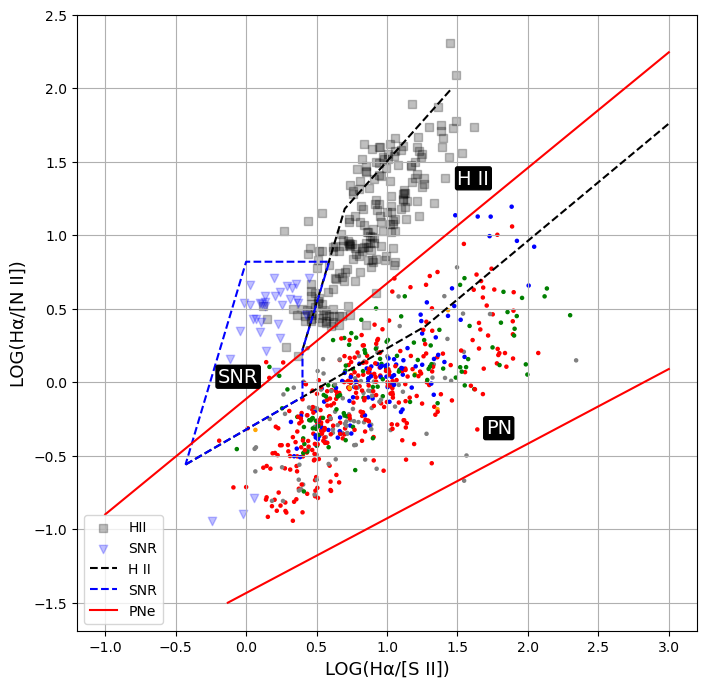

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

fontsize = 16
# Excel dosyasından verileri oku
excel_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Disc_Region.xlsx'
data = pd.read_excel(excel_path, sheet_name='smb_bpt')

# Renk haritası oluştur
color_map = {
    'Bulge': 'blue',
    'Thin Disc': 'red',
    'Thick Disk': 'green',
    'Halo': 'orange',
    'no distance': 'grey',
    'no data': 'black'
}

# Veri noktaları için renkleri belirle
colors = data['Gbileşen'].map(color_map)

# NaN değerleri kontrol et ve default renk ata (örneğin, 'black')
colors = colors.fillna('black')

# Ekspresyon verileri
x_exp_HII = [-0.43, 1.27, 3]
y_exp_HII = [-0.56, 0.38, 1.76]

x2_exp_HII = [0.40, 0.70, 1.46]
y2_exp_HII = [0.22, 1.18, 2.00]

x_exp_SNR = [-0.43, 0.40, 0.40, 0.59, 0.00, -0.43]
y_exp_SNR = [-0.56, -0.10, 0.22, 0.82, 0.82, -0.56]

x_exp_PNe = [-0.13, 3]
y_exp_PNe = [-1.50, 0.09]

x2_exp_PNe = [-1.00, 3.00]
y2_exp_PNe = [-0.899, 2.245]

# Grafik çizimi
plt.figure(figsize=(8, 8))


data4 = pd.read_excel('/Users/nurullah/python_kodlar/SMB_SNR_HII.xlsx')


x4 = data4['Log1']
y4 = data4['Log2']


plt.scatter(x4, y4, c='black', marker='s', alpha=0.25, label='HII')


data1 = pd.read_excel('/Users/nurullah/python_kodlar/SMB_SNR_HII.xlsx')


x1 = data1['LOG(Hα/[S II])']
y1 = data1['LOG(Hα/[N II])']


plt.scatter(x1, y1, c='blue', marker='v', alpha=0.25, label='SNR')


# Her bir veri setini çizim
plt.plot(x_exp_HII, y_exp_HII, 'k--', label='H II')
plt.plot(x2_exp_HII, y2_exp_HII, 'k--')

plt.plot(x_exp_SNR, y_exp_SNR, 'b--', label='SNR')

plt.plot(x_exp_PNe, y_exp_PNe, 'r-', label='PNe')
plt.plot(x2_exp_PNe, y2_exp_PNe, 'r-')

# Excel verilerini küçük kırmızı nokta olarak ekle
plt.scatter(data['LOG(HS2)'], data['LOG(HN2)'], c=colors, s=5)

# Eksen etiketleri ve başlık
plt.xlabel(('LOG(Hα/[S II])'), fontsize=13)
plt.ylabel(('LOG(Hα/[N II])'), fontsize=13)

# Bölge isimlerini ekle
#plt.text(1.65, -0.35, "PN", {"size": fontsize, "color": "Red"})
#plt.text(-0.15, 0.25, "SNR", {"size": fontsize, "color": "Blue"})
#plt.text(1.2, 1.3, "H II", {"size": fontsize, "color": "Black"})

plt.text(1.7, -0.35, "PN", fontsize=14, color='white', bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.1'))
plt.text(-0.2, 0.0, "SNR", fontsize=14, color='white', bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.1'))
plt.text(1.5, 1.35, "H II", fontsize=14, color='white', bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.1'))


# Legend ekle
plt.legend(loc='lower left')

# Grid eklemek isterseniz
plt.grid(True)

# Grafik dosyasını PNG olarak kaydet
plt.savefig('/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/SMB.png', bbox_inches='tight', dpi=300)

# Grafik gösterme
plt.show()


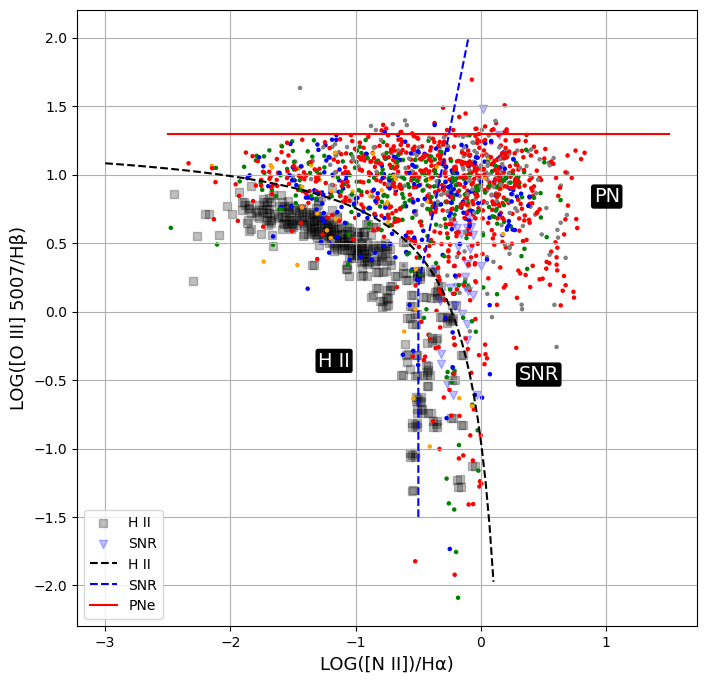

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

fontsize = 16
# Excel dosyasından verileri oku
excel_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Disc_Region.xlsx'
data = pd.read_excel(excel_path, sheet_name='smb_bpt')

# Veriler
x_exp_SNR = [-0.50, -0.50, -0.10]
y_exp_SNR = [-1.50, 0.19, 2.00]
e_exp_PNe = [-2.50, 1.50]
y_exp_PNe = [1.30, 1.30]

# Renk haritası oluştur
color_map = {
    'Bulge': 'blue',
    'Thin Disc': 'red',
    'Thick Disk': 'green',
    'Halo': 'orange',
    'no distance': 'grey',
    'no data': 'black'
}

# Veri noktaları için renkleri belirle
colors = data['Gbileşen'].map(color_map).fillna('black').tolist()

# Grafik çizimi
plt.figure(figsize=(8, 8))

data1 = pd.read_csv('/Users/nurullah/python_kodlar/BPT_a_HII_region.csv', sep='\t')
x1 = data1['LOG1']
y1 = data1['LOG2']
plt.scatter(x1, y1, c='black', marker='s', alpha=0.25, label='H II')

data3 = pd.read_csv('/Users/nurullah/python_kodlar/BPT_a_SNR.csv', sep='\t')
x3 = data3['LOG1']
y3 = data3['LOG2']
plt.scatter(x3, y3, c='blue', marker='v', alpha=0.25, label='SNR')

plt.plot(x_data, yf, 'k--', label='H II')
plt.plot(x_exp_SNR, y_exp_SNR, 'b--', label='SNR')
plt.plot(e_exp_PNe, y_exp_PNe, 'r-', label='PNe')

# Excel verilerini küçük kırmızı nokta olarak ekle
x_data = np.linspace(-2.5, 0.3, 1000)
y_data = (0.61 / (x_data - 0.47)) + 1

y_f = interp1d(x_data, y_data, 'cubic')
yf = y_f(x_data)

# Siyah kesikli çizgi ve etiketi


plt.scatter(data['LOG(N2H)'], data['LOG(O3H2)'], c=colors, s=5)

# Eksen etiketleri ve başlık
plt.xlabel('LOG([N II])/Hα)', fontsize=13)
plt.ylabel('LOG([O III] 5007/Hβ)', fontsize=13)

# Bölge isimlerini ekle
#plt.text(1.0, 0.8, "PN", {"size": fontsize, "color": "Red"})
#plt.text(0.3, -0.2, "SNR", {"size": fontsize, "color": "Blue"})
#plt.text(-1.5, 0.0, "H II", {"size": fontsize, "color": "Black"})

plt.text(0.9, 0.8, "PN", fontsize=14, color='white', bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.1'))
plt.text(0.3, -0.5, "SNR", fontsize=14, color='white', bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.1'))
plt.text(-1.3, -0.4, "H II", fontsize=14, color='white', bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.1'))

# Legend ekleme
plt.legend(loc='lower left')

# Grid eklemek istiyorsanız kullanabilirsiniz.
plt.grid(True)

# Grafik dosyasını PNG olarak kaydetme
plt.savefig('/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/BPTa.png', bbox_inches='tight', dpi=300)

# Grafik gösterme
plt.show()

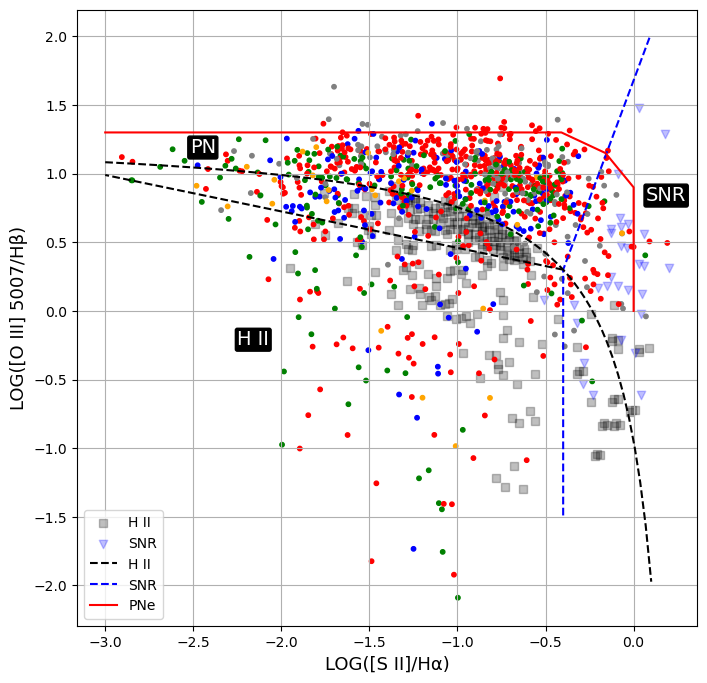

In [49]:
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fontsize = 16
# Excel dosyasından verileri oku
excel_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Disc_Region.xlsx'
data = pd.read_excel(excel_path, sheet_name='smb_bpt')


# Renk haritası oluştur
color_map = {
    'Bulge': 'blue',
    'Thin Disc': 'red',
    'Thick Disk': 'green',
    'Halo': 'orange',
    'no distance': 'grey',
    'no data': 'black'
}

# Veri noktaları için renkleri belirle
colors = data['Gbileşen'].map(color_map).fillna('black').tolist()

# Grafik çizimi
plt.figure(figsize=(8, 8))

# Her bir veri setini çizim
# Veriler
data1 = pd.read_excel('/Users/nurullah/python_kodlar/BPT_b_HII_regions.xlsx')
 
x1 = data1['LOG1']
y1 = data1['LOG2']
 
plt.scatter(x1, y1, c='black', marker='s', alpha=0.25, label='H II')
 
data2 = pd.read_csv('/Users/nurullah/python_kodlar/BPT_b_SNR.csv', sep='\t')
 
x2 = data2['LOG1']
y2 = data2['LOG2']
 
plt.scatter(x2, y2, c='blue', marker='v', alpha=0.25, label='SNR')
 
x_exp_HII = [-0.40, -3]
y_exp_HII = [0.30, 0.99]
x_exp_SNR = [-0.40, -0.40, 0.09]
y_exp_SNR = [-1.49, 0.30, 1.99]
x_exp_PNe = [-3, -0.41, -0.16, -0.00, -0.00]
y_exp_PNe = [1.30, 1.30, 1.15, 0.90, 0.00]

plt.plot(x_exp_HII, y_exp_HII, 'k--', label='H II')
plt.plot(x_exp_SNR, y_exp_SNR, 'b--', label='SNR')
plt.plot(x_exp_PNe, y_exp_PNe, 'r-', label='PNe')

# Excel verilerini küçük nokta olarak ekle
x = data['LOG(S2H)']
y = data['LOG(O3H2)']

x_data = np.linspace(-3, 0.1, 100)
y_data = (0.72 / (x_data - 0.32)) + 1.30

y_f = interp1d(x_data, y_data, 'cubic')
yf = y_f(x_data)
plt.scatter(data['LOG(S2H)'], data['LOG(O3H2)'], c=colors, s=10)

# Plot the curve
plt.plot(x_data, yf, 'k--')
# Eksen etiketleri ve başlık
plt.xlabel('LOG([S II]/Hα)', fontsize=13)
plt.ylabel('LOG([O III] 5007/Hβ)', fontsize=13)

# Bölge isimlerini ekle
#plt.text(-0.8, 0.8, "PN", {"size": fontsize, "color": "Red"})
#plt.text(0.09, 0.10, "SNR", {"size": fontsize, "color": "Blue"})
#plt.text(-2.0, -0.7, "H II", {"size": fontsize, "color": "Black"})

plt.text(-2.52, 1.15, "PN", fontsize=14, color='white', bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.1'))
plt.text(0.07, 0.8, "SNR", fontsize=14, color='white', bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.1'))
plt.text(-2.25, -0.25, "H II", fontsize=14, color='white', bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.1'))


# Legend ekleme
plt.legend(loc='lower left')

# Grid eklemek istiyorsanız kullanabilirsiniz.
plt.grid(True)

# Grafik dosyasını PNG olarak kaydetme
plt.savefig('/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/BPTb.png', bbox_inches='tight', dpi=300)

# Grafik gösterme
plt.show()

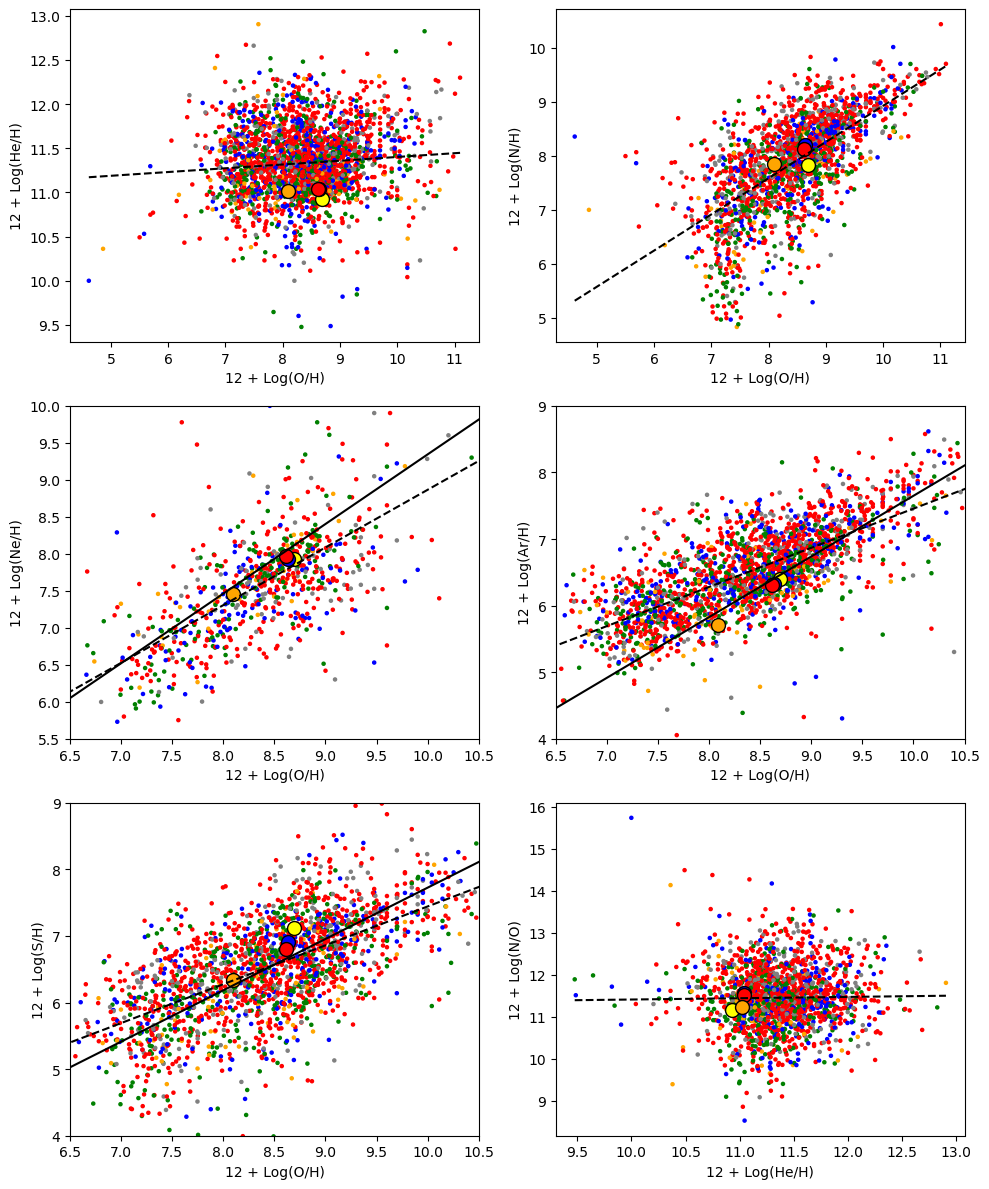

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import linregress
import os

# Excel dosyasını oku
dosya_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Disc_Region.xlsx"
sayfa_adi = "Total_abundance"
data = pd.read_excel(dosya_yolu, sheet_name=sayfa_adi)

# Sütun başlıklarıyla birlikte verileri al
He_H = data["He/H"] + 12.0
N_H = data["N/H"] + 12.0
O_H = data["O/H"] + 12.0
Ne_H = data["Ne/H"] + 12.0
Ar_H = data["Ar/H"] + 12.0
S_H = data["S/H"] + 12.0

# Solar, disk, bulge ve halo değerleri
sol = [-1.07, -4.17, -3.31, -4.07, -5.6, -4.88]
disk = [-0.96, -3.87, -3.39, -4.03, -5.69, -5.20]
bulge = [-0.96, -3.80, -3.37, -4.07, -5.68, -5.09]
halo = [-0.98, -4.15, -3.91, -4.54, -6.29, -5.66]

# Renk haritası oluştur
color_map = {
    'Bulge': 'blue',
    'Thin Disc': 'red',
    'Thick Disk': 'green',
    'Halo': 'orange',
    'no distance': 'grey',
    'no data': 'black'
}

# Veri noktaları için renkleri belirle
colors = data['Gbileşen'].map(color_map)

# Trend çizgisi ve R^2 değerlerini kaydetmek için liste
trend_info = []
component_trend_info = []

# Trend çizgisi eklemek için yardımcı fonksiyon
def add_trend_line(ax, x_data, y_data, label):
    mask = np.isfinite(x_data) & np.isfinite(y_data)
    x_data_clean = x_data[mask]
    y_data_clean = y_data[mask]
    
    if len(x_data_clean) > 1:
        # Linear regression with standard error
        slope, intercept, r_value, p_value, std_err = linregress(x_data_clean, y_data_clean)
        
        x_values = np.linspace(min(x_data_clean), max(x_data_clean), 100)
        y_values = slope * x_values + intercept
        ax.plot(x_values, y_values, color='black', linestyle='--')
        
        # Calculate confidence intervals
        n = len(x_data_clean)
        t = 2.306  # 95% confidence interval for large sample sizes (df > 30)
        slope_ci = t * std_err
        intercept_ci = t * std_err * np.sqrt(np.sum((x_data_clean - np.mean(x_data_clean))**2) / n)
        
        trend_info.append(f"{label}: y = ({intercept:.4f} ± {intercept_ci:.4f}) + ({slope:.4f} ± {slope_ci:.4f})x, R^2 = {r_value**2:.4f}, n = {n}")

# Her bileşen için trend çizgisi hesaplamak için yardımcı fonksiyon
def calculate_component_trend(x_data, y_data, component, label):
    mask = (data['Gbileşen'] == component) & np.isfinite(x_data) & np.isfinite(y_data)
    x_data_clean = x_data[mask]
    y_data_clean = y_data[mask]
    
    if len(x_data_clean) > 1:
        # Linear regression with standard error
        slope, intercept, r_value, p_value, std_err = linregress(x_data_clean, y_data_clean)
        
        # Calculate confidence intervals
        n = len(x_data_clean)
        t = 2.306  # 95% confidence interval for large sample sizes (df > 30)
        slope_ci = t * std_err
        intercept_ci = t * std_err * np.sqrt(np.sum((x_data_clean - np.mean(x_data_clean))**2) / n)
        
        component_trend_info.append(f"{label} ({component}): y = ({intercept:.4f} ± {intercept_ci:.4f}) + ({slope:.4f} ± {slope_ci:.4f})x, R^2 = {r_value**2:.4f}, n = {n}")

# Grafik oluştur
fig, axs = plt.subplots(3, 2, figsize=(10, 12))

#####################     He     #####################
axs[0, 0].scatter(O_H, He_H, color=colors, s=5)
axs[0, 0].set_xlabel('12 + Log(O/H)')
axs[0, 0].set_ylabel('12 + Log(He/H)')
axs[0, 0].scatter(sol[2] + 12.0, sol[0] + 12.0, color='yellow', edgecolors='black', linewidths=1, s=100)
axs[0, 0].scatter(bulge[2] + 12.0, bulge[0] + 12.0, color='blue', edgecolors='black', linewidths=1, s=100)
axs[0, 0].scatter(disk[2] + 12.0, disk[0] + 12.0, color='red', edgecolors='black', linewidths=1, s=100)
axs[0, 0].scatter(halo[2] + 12.0, halo[0] + 12.0, color='orange', edgecolors='black', linewidths=1, s=100)
add_trend_line(axs[0, 0], O_H, He_H, 'He vs O')
for component in color_map.keys():
    calculate_component_trend(O_H, He_H, component, 'He vs O')

#####################     N     #####################
axs[0, 1].scatter(O_H, N_H, color=colors, s=5)
axs[0, 1].set_xlabel('12 + Log(O/H)')
axs[0, 1].set_ylabel('12 + Log(N/H)')
axs[0, 1].scatter(sol[2] + 12.0, sol[1] + 12.0, color='yellow', edgecolors='black', linewidths=1, s=100)
axs[0, 1].scatter(bulge[2] + 12.0, bulge[1] + 12.0, color='blue', edgecolors='black', linewidths=1, s=100)
axs[0, 1].scatter(disk[2] + 12.0, disk[1] + 12.0, color='red', edgecolors='black', linewidths=1, s=100)
axs[0, 1].scatter(halo[2] + 12.0, halo[1] + 12.0, color='orange', edgecolors='black', linewidths=1, s=100)
add_trend_line(axs[0, 1], O_H, N_H, 'N vs O')
for component in color_map.keys():
    calculate_component_trend(O_H, N_H, component, 'N vs O')

#####################     Ne     #####################
m = 0.94
b = -0.056
x_values = np.linspace(6.5, 10.5, 100)
y_values = m * x_values + b
axs[1, 0].plot(x_values, y_values, color='black', linestyle='solid')
axs[1, 0].scatter(O_H, Ne_H, color=colors, s=5)
axs[1, 0].set_xlabel('12 + Log(O/H)')
axs[1, 0].set_ylabel('12 + Log(Ne/H)')
axs[1, 0].set_ylim(5.5, 10.0)
axs[1, 0].set_xlim(6.5, 10.5)
axs[1, 0].scatter(sol[2] + 12.0, sol[3] + 12.0, color='yellow', edgecolors='black', linewidths=1, s=100)
axs[1, 0].scatter(bulge[2] + 12.0, bulge[3] + 12.0, color='blue', edgecolors='black', linewidths=1, s=100)
axs[1, 0].scatter(disk[2] + 12.0, disk[3] + 12.0, color='red', edgecolors='black', linewidths=1, s=100)
axs[1, 0].scatter(halo[2] + 12.0, halo[3] + 12.0, color='orange', edgecolors='black', linewidths=1, s=100)
add_trend_line(axs[1, 0], O_H, Ne_H, 'Ne vs O')
for component in color_map.keys():
    calculate_component_trend(O_H, Ne_H, component, 'Ne vs O')

#####################     Ar     #####################
m = 0.91
b = -1.45
x_values = np.linspace(6.5, 10.5, 100)
y_values = m * x_values + b
axs[1, 1].plot(x_values, y_values, color='black', linestyle='solid')
axs[1, 1].scatter(O_H, Ar_H, color=colors, s=5)
axs[1, 1].set_xlabel('12 + Log(O/H)')
axs[1, 1].set_ylabel('12 + Log(Ar/H)')
axs[1, 1].set_ylim(4, 9.0)
axs[1, 1].set_xlim(6.5, 10.5)
axs[1, 1].scatter(sol[2] + 12.0, sol[4] + 12.0, color='yellow', edgecolors='black', linewidths=1, s=100)
axs[1, 1].scatter(bulge[2] + 12.0, bulge[4] + 12.0, color='blue', edgecolors='black', linewidths=1, s=100)
axs[1, 1].scatter(disk[2] + 12.0, disk[4] + 12.0, color='red', edgecolors='black', linewidths=1, s=100)
axs[1, 1].scatter(halo[2] + 12.0, halo[4] + 12.0, color='orange', edgecolors='black', linewidths=1, s=100)
add_trend_line(axs[1, 1], O_H, Ar_H, 'Ar vs O')
for component in color_map.keys():
    calculate_component_trend(O_H, Ar_H, component, 'Ar vs O')

#####################     S     #####################
m = 0.77
b = 0.024
x_values = np.linspace(6.5, 10.5, 100)
y_values = m * x_values + b
axs[2, 0].plot(x_values, y_values, color='black', linestyle='solid')
axs[2, 0].scatter(O_H, S_H, color=colors, s=5)
axs[2, 0].set_xlabel('12 + Log(O/H)')
axs[2, 0].set_ylabel('12 + Log(S/H)')
axs[2, 0].set_ylim(4, 9.0)
axs[2, 0].set_xlim(6.5, 10.5)
axs[2, 0].scatter(sol[2] + 12.0, sol[5] + 12.0, color='yellow', edgecolors='black', linewidths=1, s=100)
axs[2, 0].scatter(bulge[2] + 12.0, bulge[5] + 12.0, color='blue', edgecolors='black', linewidths=1, s=100)
axs[2, 0].scatter(disk[2] + 12.0, disk[5] + 12.0, color='red', edgecolors='black', linewidths=1, s=100)
axs[2, 0].scatter(halo[2] + 12.0, halo[5] + 12.0, color='orange', edgecolors='black', linewidths=1, s=100)
add_trend_line(axs[2, 0], O_H, S_H, 'S vs O')
for component in color_map.keys():
    calculate_component_trend(O_H, S_H, component, 'S vs O')

#####################     NO     #####################     
N_O = pd.Series([N_H_val - O_H_val + 12.0 for N_H_val, O_H_val in zip(N_H, O_H)])
axs[2, 1].scatter(He_H, N_O, color=colors, s=5)
axs[2, 1].set_xlabel('12 + Log(He/H)')
axs[2, 1].set_ylabel('12 + Log(N/O)')
axs[2, 1].scatter(10.93, 12.0 - 0.85, color='yellow', edgecolors='black', linewidths=1, s=100)
axs[2, 1].scatter(bulge[0] + 12.0, 12.0 + bulge[1] - bulge[2], color='blue', edgecolors='black', linewidths=1, s=100)
axs[2, 1].scatter(disk[0] + 12.0, 12.0 + disk[1] - disk[2], color='red', edgecolors='black', linewidths=1, s=100)
axs[2, 1].scatter(halo[0] + 12.0, 12.0 + halo[1] - disk[2], color='orange', edgecolors='black', linewidths=1, s=100)
add_trend_line(axs[2, 1], He_H, N_O, 'N/O vs He')
for component in color_map.keys():
    calculate_component_trend(He_H, N_O, component, 'N/O vs He')

# Grafik ayarları
plt.tight_layout()
plt.savefig('/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Total_abun.pdf')   # save the figure to file
plt.show()

output_dir = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/'
trend_info_file = os.path.join(output_dir, 'trend_info.txt')

with open(trend_info_file, 'w') as file:
    file.write("Trend Line Information:\n")
    for info in trend_info:
        file.write(info + "\n")

    file.write("\nComponent-wise Trend Line Information:\n")
    for info in component_trend_info:
        file.write(info + "\n")

In [ ]:
####### makaletablo2 ####### neat çıktılarından hdul1den verileri alırken hata hesabını yaparak excel 
#dosyalarına kaydedip. daha sonraki kodda tek bir excel dosyasında birleştirmek. 3. kodda ise tablo oluşturduğumuz 
#değerleri seçerek yeni bir excel dosyası seçmek

from astropy.io import fits
import pandas as pd
import os

# Dizin içindeki tüm FITS dosyalarını al
fits_directory = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/neat_out/'
fits_file_paths = [os.path.join(fits_directory, file) for file in sorted(os.listdir(fits_directory)) if file.endswith('.fits')]

# Excel dosyalarının kaydedileceği dizin
output_directory = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/neat_to_excel/deneme/'
os.makedirs(output_directory, exist_ok=True)

# Her 50 FITS dosyası için ayrı bir Excel dosyası oluştur
batch_size = 50

# Dosya isimlerini saklayacak bir sözlük oluştur
file_names_dict = {}

for i in range(0, len(fits_file_paths), batch_size):
    batch_fits_files = fits_file_paths[i:i + batch_size]

    # Excel dosyasının ismini belirle
    excel_file_name = f'batch_{i // batch_size + 1}.xlsx'
    excel_file_path = os.path.join(output_directory, excel_file_name)

    # Her FITS dosyası için döngü
    with pd.ExcelWriter(excel_file_path, engine='openpyxl') as writer:
        for fits_file_path in batch_fits_files:
            # Open the FITS file
            with fits.open(fits_file_path) as hdul:
                # Access the data and header of the LINES BinTableHDU (hdul[2])
                data = hdul[1].data

                # Convert the FITS data to a pandas DataFrame
                df = pd.DataFrame(data)

                # Sadece belirtilen sütunları seç
                selected_columns = ['WlenRest', 'Flux', 'Uncertainty', 'Ion', 'DereddenedFlux', 'DereddenedFluxLo', 'DereddenedFluxHi']
                df_selected = df[selected_columns]

                # Negatif ve sıfıra eşit olan değerlere sahip satırları filtrele ve sil
                df_selected = df_selected[df_selected['Flux'] > 0.01]

                # Yeni sütunu ekle
                df_selected['AdjustedFlux'] = ((df_selected['DereddenedFluxLo'] - df_selected['DereddenedFlux']) + (df_selected['DereddenedFlux'] - df_selected['DereddenedFluxHi'])) / 2

                # Sadece gerekli sütunları seç
                final_columns = ['WlenRest', 'Flux', 'Uncertainty', 'Ion', 'DereddenedFlux', 'AdjustedFlux']
                df_final = df_selected[final_columns]

                # Sayfa adını dosya isminin ilk 31 karakteri olarak ayarla
                sheet_name = os.path.basename(fits_file_path)[:31]
                
                # Tam dosya ismini sözlüğe ekle
                file_names_dict[sheet_name] = os.path.basename(fits_file_path)

                # Verileri içeren DataFrame'i yeni bir sayfada kaydet
                df_final.to_excel(writer, sheet_name=sheet_name, index=False)

    print(f"Data has been successfully exported to {excel_file_path}")

# Dosya isimlerini bir CSV dosyasına kaydedelim
file_names_dict_path = os.path.join(output_directory, 'file_names_dict.csv')
file_names_df = pd.DataFrame(list(file_names_dict.items()), columns=['SheetName', 'FullFileName'])
file_names_df.to_csv(file_names_dict_path, index=False)


In [ ]:
import pandas as pd
import os

# Excel dosyalarının bulunduğu klasörün tam yolu
excel_folder_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/neat_to_excel/deneme/'

# Tüm Excel dosyalarını al
excel_files = [os.path.join(excel_folder_path, file) for file in sorted(os.listdir(excel_folder_path)) if file.endswith('.xlsx')]

# Dosya isimleri sözlüğünü oku
file_names_dict_path = os.path.join(excel_folder_path, 'file_names_dict.csv')
file_names_df = pd.read_csv(file_names_dict_path)
file_names_dict = dict(zip(file_names_df['SheetName'], file_names_df['FullFileName']))

# Birleştirilecek verileri tutacak ana DataFrame'i oluştur
main_df = pd.DataFrame()

# Her Excel dosyası için döngü
for excel_file_path in excel_files:
    # Excel dosyasını oku
    df = pd.read_excel(excel_file_path, sheet_name=None)

    # Her sayfa için döngü
    for sheet_name, sheet_data in df.items():
        # 'WlenRest', 'Ion', 'DereddenedFlux', 'AdjustedFlux' sütunlarını içeren sayfaları seç
        if all(col in sheet_data.columns for col in ['WlenRest', 'Ion', 'DereddenedFlux', 'AdjustedFlux']):
            full_file_name = file_names_dict.get(sheet_name, sheet_name)
            # Eğer ana DataFrame boşsa, direkt ekle
            if main_df.empty:
                main_df = sheet_data[['WlenRest', 'Ion', 'DereddenedFlux', 'AdjustedFlux']].copy()
                main_df.rename(columns={
                    'DereddenedFlux': f'DereddenedFlux_{full_file_name}',
                    'AdjustedFlux': f'AdjustedFlux_{full_file_name}'
                }, inplace=True)
            else:
                # Ana DataFrame'de 'WlenRest' ve 'Ion' sütunlarına göre birleştirme yap
                main_df = main_df.merge(
                    sheet_data[['WlenRest', 'Ion', 'DereddenedFlux', 'AdjustedFlux']],
                    on=['WlenRest', 'Ion'],
                    how='outer',
                    suffixes=('', f'_{full_file_name}')
                )
                main_df.rename(columns={
                    'DereddenedFlux': f'DereddenedFlux_{full_file_name}',
                    'AdjustedFlux': f'AdjustedFlux_{full_file_name}'
                }, inplace=True)

# NaN değerleri '-' ile değiştir
main_df.fillna('-', inplace=True)

# 'WlenRest' sütununa göre küçükten büyüğe sırala
main_df.sort_values('WlenRest', inplace=True)

# Excel dosyasına ekleyeceğimiz sayfa adı
new_sheet_name = 'DereddenedAdjustedFlux_Tablo'

# Yeni bir Excel dosyası oluştur
output_excel_file_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/neat_to_excel/deneme/DereddenedErrorFlux_tablo.xlsx'
with pd.ExcelWriter(output_excel_file_path, engine='openpyxl') as writer:
    main_df.to_excel(writer, sheet_name=new_sheet_name, index=False)

print(f"Merged, sorted data has been successfully added to the sheet {new_sheet_name} in the Excel file.")


In [ ]:
import os
import pandas as pd
from astropy.io import fits

# FITS dosyalarının bulunduğu klasör yolu
fits_folder_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/neat_out/'
excel_output_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/elementelabundance.xlsx'

# Dosya isimlerini al
fits_files = [file for file in os.listdir(fits_folder_path) if file.endswith('.fits')]

# Belirli satır indeksleri ve isimleri
row_indices = [83, 89, 95, 101, 106, 110, 115, 118]
row_names = ['C_H', 'N_H', 'O_H', 'Ne_H', 'Ar_H', 'S_H', 'Cl_H', 'He_H']

# DataFrame oluşturmak için boş bir liste
data_list = []

# Her FITS dosyası için belirli satırlardaki değerleri al
for fits_file in fits_files:
    file_path = os.path.join(fits_folder_path, fits_file)
    
    # FITS dosyasını aç
    with fits.open(file_path) as hdul:
        # Verilerin bulunduğu tabloyu al (genellikle 'PRIMARY' veya 'TABLE')
        data = hdul[2].data
        
        # Belirli satırlardaki değerleri al
        selected_rows = data[row_indices]
        
        # Her satırdaki 4 sütundan 3'ünü seç (ilk sütun her zaman aynı olduğundan)
        row_data = [fits_file]  # İlk sütuna FITS dosyasının ismini ekle
        for row in selected_rows:
            row_data.extend(list(row[1:4]))  # İlk sütun hariç diğer 3 sütunu ekle
        
        data_list.append(row_data)

# Sütun isimlerini oluştur
columns = ['FITS_File']
for name in row_names:
    columns.extend([f'{name}_Value', f'{name}_UpperValue', f'{name}_LowerValue'])

# DataFrame oluştur
df = pd.DataFrame(data_list, columns=columns)

# Excel dosyasına yaz
df.to_excel(excel_output_path, index=False)

print(f"FITS dosyası: {excel_output_path}")

In [ ]:
#### satırda akılar,  sütunlarda ise tayf bilgileri var


import pandas as pd

# Merged Excel dosyasının tam yolu
merged_excel_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/neat_to_excel/deneme/DereddenedErrorFlux_tablo.xlsx'

# Filtrelenecek WlenRest değerleri
wlenrest_values = [
    3726.039, 3728.82, 4089.29, 4101.74, 4340.47, 4363.20, 4471.50,
    4649.12, 4661.62, 4711.37, 4740.16, 4958.91, 5006.83, 5191.81,
    5517.66, 5537.60, 5577.33, 5754.60, 5875.66, 6300.33, 6363.77,
    6548.10, 6562.77, 6583.50, 6678.16, 6716.43, 6730.81, 7005.66,
    7135.79, 7281.35, 7751.06
]


# Merged Excel dosyasını oku
main_df = pd.read_excel(merged_excel_path, sheet_name='Dflux_Error')

# Sadece belirli WlenRest değerlerine sahip olan satırları seç
filtered_df = main_df[main_df['WlenRest'].isin(wlenrest_values)]

# Yeni bir Excel dosyası oluştur
filtered_excel_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/Makale_DereddenedErrorFlux_Tablo.xlsx'
with pd.ExcelWriter(filtered_excel_path, engine='openpyxl') as writer:
    filtered_df.to_excel(writer, sheet_name='Filtered_DereddenedFlux_Tablo', index=False)

print(f"Filtered data has been successfully added to the new Excel file at {filtered_excel_path}.")

In [ ]:
#### satırda tayf bilgileri sütunlarda ise akı ve hataları var

import os
import pandas as pd
from astropy.io import fits

# Wavelength values to search for, formatted to 7 characters
wlenrest_values = [
    3726.03, 3728.82, 4089.29, 4101.74, 4340.47, 4363.21, 4471.50,
    4649.13, 4661.63, 4711.37, 4740.17, 4958.91, 5006.84, 5191.82,
    5517.66, 5537.60, 5577.34, 5754.60, 5875.66, 6300.34, 6363.78,
    6548.10, 6562.77, 6583.50, 6678.16, 6716.44, 6730.82, 7005.67,
    7135.80, 7281.35, 7751.06
]

# Convert wavelength values to 7-character strings
wlenrest_strings = [f"{wlenrest:.2f}".rjust(7, '0') for wlenrest in wlenrest_values]

# Data list to store the results
data_list = []

# Iterate over each FITS file
for fits_file in fits_files:
    file_path = os.path.join(fits_folder_path, fits_file)
    
    # Open the FITS file
    with fits.open(file_path) as hdul:
        # Get the data from the table (hdul[1])
        data = hdul[1].data
        
        # Prepare a list to store data for the current FITS file
        fits_data = [fits_file]  # First column: FITS file name
        
        for wlenrest_string in wlenrest_strings:
            matching_row = None
            for row in data:
                # Compare the first 7 characters of the second column's value
                if f"{row[1]:.2f}".rjust(7, '0') == wlenrest_string:
                    matching_row = row
                    break
            
            if matching_row is not None:
                # Add the last three column values
                fits_data.extend(matching_row[-6:-3])
            else:
                # Add empty values if wavelength is not found
                fits_data.extend(['-', '-', '-'])
        
        # Append the data for the current FITS file to the list
        data_list.append(fits_data)

# Create column names for the DataFrame
columns = ['FITS File'] + [f'{wlenrest_string}_Col_{i+1}' for wlenrest_string in wlenrest_strings for i in range(3)]

# Create the DataFrame
df = pd.DataFrame(data_list, columns=columns)

# Save the DataFrame to an Excel file
output_file = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/deneme/neat_to_excel/deneme/DereddenedFlux.xlsx'
df.to_excel(output_file, index=False)

print(f"Veriler '{output_file}' dosyasına kaydedildi.")

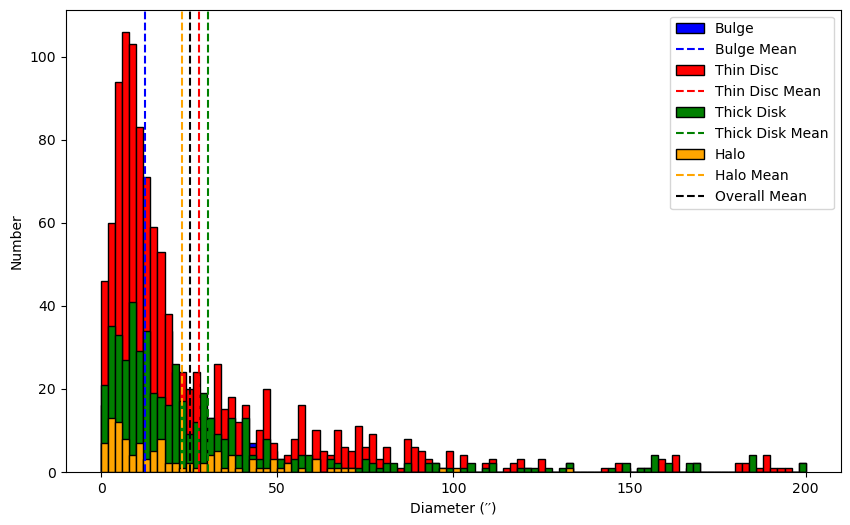

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from openpyxl import load_workbook

# Excel dosyasını oku
excel_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Disc_Region.xlsx"
renklendirilmis_df = pd.read_excel(excel_yolu, sheet_name='düşeyara')

# Kullanılacak sütunları seç
rgeo_sutunu = renklendirilmis_df['MajDiam']
gbilesen_sutunu = renklendirilmis_df['Gbileşen']

# Verileri sayısal değerlere dönüştür
rgeo_sutunu = pd.to_numeric(rgeo_sutunu, errors='coerce')

# Filtreleme işlemi: MajDiam değeri 200 ve altında olanları seç
filtered_df = renklendirilmis_df[rgeo_sutunu <= 200]
filtered_rgeo_sutunu = filtered_df['MajDiam']
filtered_gbilesen_sutunu = filtered_df['Gbileşen']

# Renklerin ve etiketlerin belirlenmesi
renk_etiketleri = {
    'Bulge': 'blue',          # Bulge ise mavi
    'Thin Disc': 'red',       # Thin Disc ise kırmızı
    'Thick Disk': 'green',    # Thick Disk ise yeşil
    'Halo': 'orange',         # Halo ise turuncu
}

bins = np.arange(0, 201, 2)  # Histogram aralığı 0'dan 200'e kadar

# Ortalama değerleri saklayacak bir sözlük oluştur
ortalama_degerler = {}

# Histogram verilerini saklayacak bir liste oluştur
hist_data = []

# Her bileşen için histogram verilerini hesapla ve sakla
for component, color in renk_etiketleri.items():
    component_values = filtered_rgeo_sutunu[filtered_gbilesen_sutunu == component]
    counts, bins = np.histogram(component_values, bins=bins)
    hist_data.append((component, counts, bins, color))

    # Ortalama değeri hesapla ve sakla
    mean_value = component_values.mean()
    ortalama_degerler[component] = mean_value

# Verileri sayıya göre sırala: En küçük bin sayısına sahip histogram en önde olacak şekilde
hist_data.sort(key=lambda x: np.min(x[1]))  # En küçük bin sayısına göre sırala

# Tek bir histogram üzerinde tüm bileşenleri çiz
plt.figure(figsize=(10, 6))

for component, counts, bins, color in hist_data:
    plt.hist(bins[:-1], bins=bins, weights=counts, label=component, color=color, edgecolor='black')

    # Ortalama çizgisini ekle (dikey çizgi)
    mean_value = ortalama_degerler[component]
    plt.axvline(x=mean_value, color=color, linestyle='--', label=f'{component} Mean')

# Tüm verilerin ortalamasını hesapla ve çiz
all_mean_value = filtered_rgeo_sutunu.mean()
plt.axvline(x=all_mean_value, color='black', linestyle='--', label='Overall Mean')

# X eksenindeki etiketleri özelleştir
plt.xticks(np.arange(0, 201, 50))  # 0'dan 200'e kadar 50'şer artışlarla

plt.xlabel('Diameter (′′)')
plt.ylabel('Number')
plt.legend(title='')

# Grafik dosyası yolunu belirle
save_path = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.3MajDiameter.png"
plt.savefig(save_path)

# Grafiği göster
plt.show()

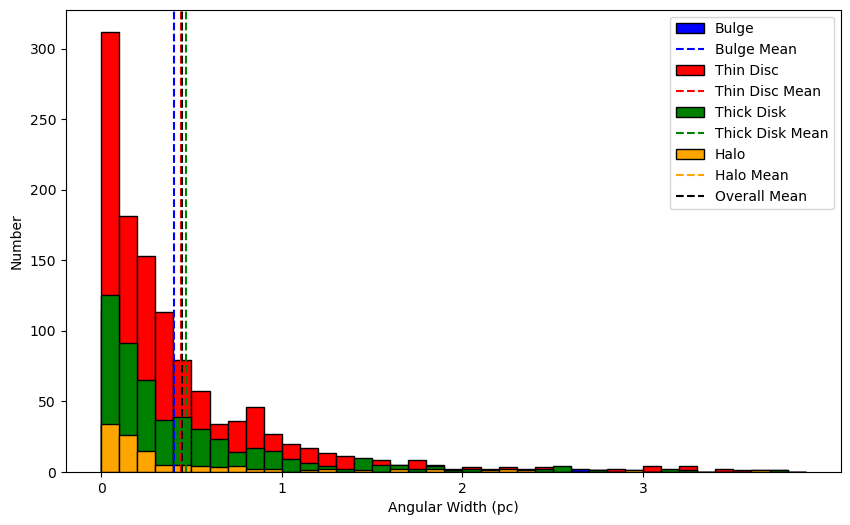

In [144]:
# Kullanılacak sütunları seç
acisal_genislik_sutunu = renklendirilmis_df['Açısal_genişlik']
gbilesen_sutunu = renklendirilmis_df['Gbileşen']

# Verileri sayısal değerlere dönüştür
acisal_genislik_sutunu = pd.to_numeric(acisal_genislik_sutunu, errors='coerce')

# Filtreleme işlemi: Açısal_genişlik değeri 6'dan küçük olanları seç
filtered_df = renklendirilmis_df[acisal_genislik_sutunu < 4]
filtered_acisal_genislik_sutunu = filtered_df['Açısal_genişlik']
filtered_gbilesen_sutunu = filtered_df['Gbileşen']

# Histogram için bin aralıkları (0'dan 6'ya kadar)
bins = np.arange(0, 4, 0.1)  # Histogram aralığı 0'dan 6'ya kadar, 0.1 artışlarla

# Ortalama değerleri saklayacak bir sözlük oluştur
ortalama_degerler = {}

# Histogram verilerini saklayacak bir liste oluştur
hist_data = []

# Her bileşen için histogram verilerini hesapla ve sakla
for component, color in renk_etiketleri.items():
    component_values = filtered_acisal_genislik_sutunu[filtered_gbilesen_sutunu == component]
    counts, bins = np.histogram(component_values, bins=bins)
    hist_data.append((component, counts, bins, color))

    # Ortalama değeri hesapla ve sakla
    mean_value = component_values.mean()
    ortalama_degerler[component] = mean_value

# Verileri sayıya göre sırala: En küçük bin sayısına sahip histogram en önde olacak şekilde
hist_data.sort(key=lambda x: np.min(x[1]))  # En küçük bin sayısına göre sırala

# Tek bir histogram üzerinde tüm bileşenleri çiz
plt.figure(figsize=(10, 6))

for component, counts, bins, color in hist_data:
    plt.hist(bins[:-1], bins=bins, weights=counts, label=component, color=color, edgecolor='black')

    # Ortalama çizgisini ekle (dikey çizgi)
    mean_value = ortalama_degerler[component]
    plt.axvline(x=mean_value, color=color, linestyle='--', label=f'{component} Mean')

# Tüm verilerin ortalamasını hesapla ve çiz
all_mean_value = filtered_acisal_genislik_sutunu.mean()
plt.axvline(x=all_mean_value, color='black', linestyle='--', label='Overall Mean')

# X eksenindeki etiketleri özelleştir
plt.xticks(np.arange(0, 4, 1))  # 0'dan 6'ya kadar 1'er artışlarla

plt.xlabel('Angular Width (pc)')
plt.ylabel('Number')
plt.legend(title='')

# Grafik dosyası yolunu belirle
save_path = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/AngularWidth.png"
plt.savefig(save_path)

# Grafiği göster
plt.show()

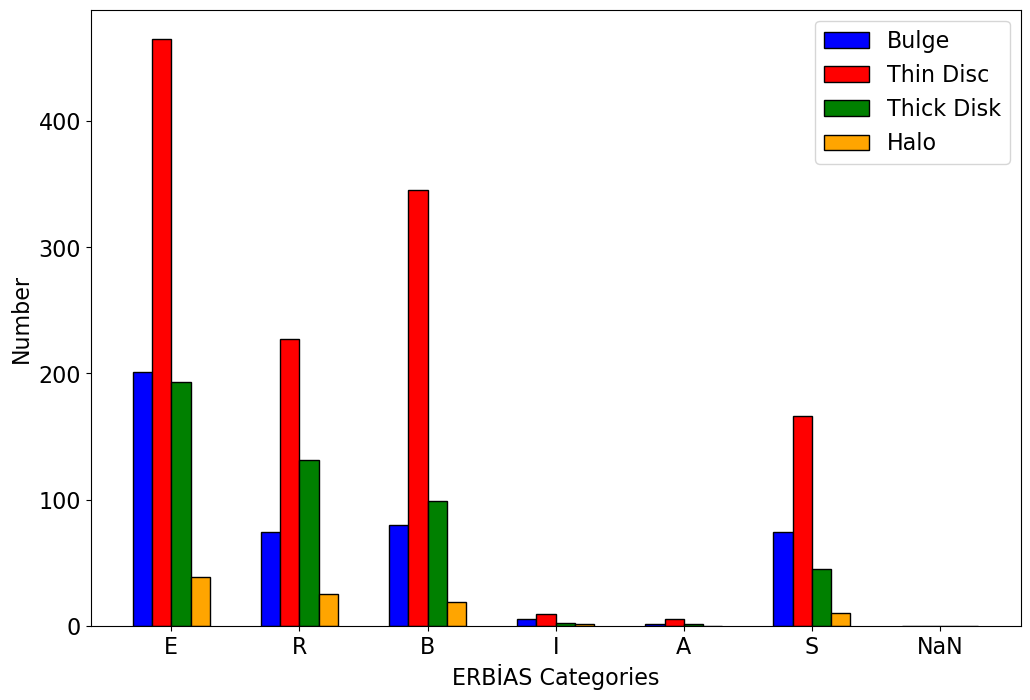

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Excel dosyasını oku
excel_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Disc_Region.xlsx"
df = pd.read_excel(excel_yolu, sheet_name='Maj_Angular_ERBIAS_SPARM')

# Kullanılacak sütunları seç
erbias_sutunu = df['ERBIAS']
gbilesen_sutunu = df['Gbileşen']

# '0' olan değerleri 'NaN' ile değiştir
erbias_sutunu.replace(0, np.nan, inplace=True)

# Kategori renklerini tanımla
renk_etiketleri = {
    'Bulge': 'blue',          # Bulge ise mavi
    'Thin Disc': 'red',       # Thin Disc ise kırmızı
    'Thick Disk': 'green',    # Thick Disk ise yeşil
    'Halo': 'orange',         # Halo ise turuncu
}

# E, R, B, İ, A, S kategorilerini ve NaN (eski 0) için histogram oluştur
categories = ['E', 'R', 'B', 'I', 'A', 'S', np.nan]
category_names = ['E', 'R', 'B', 'I', 'A', 'S', 'NaN']

# Histogramın genel özellikleri
bar_width = 0.15  # Her bir bileşen için sütun genişliği
x_positions = np.arange(len(categories))  # Her kategori için x eksenindeki pozisyonlar
offset = np.zeros_like(x_positions, dtype=float)  # Her kategori için başlangıçta kaydırma 0

plt.figure(figsize=(12, 8))

# Her bileşen için sütunları çiz
for component, color in renk_etiketleri.items():
    counts = []
    
    for category in categories:
        filtered_gbilesen_sutunu = gbilesen_sutunu[erbias_sutunu == category]
        component_count = filtered_gbilesen_sutunu[filtered_gbilesen_sutunu == component].count()
        counts.append(component_count)
    
    # Sütunları çiz
    plt.bar(x_positions + offset, counts, bar_width, color=color, edgecolor='black', label=component)
    offset += bar_width  # Sonraki bileşen için kaydırmayı artır

# X eksenini özelleştir
plt.xticks(x_positions + bar_width * 1.5, category_names)  # Kategorileri ortalamak için kaydırma
plt.xlabel('ERBİAS Categories')
plt.ylabel('Number')
plt.legend(loc='upper right')

# Grafik dosyası yolunu belirle
save_path = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/ERBIAS.png"
plt.savefig(save_path, bbox_inches='tight')

# Grafiği göster
plt.show()

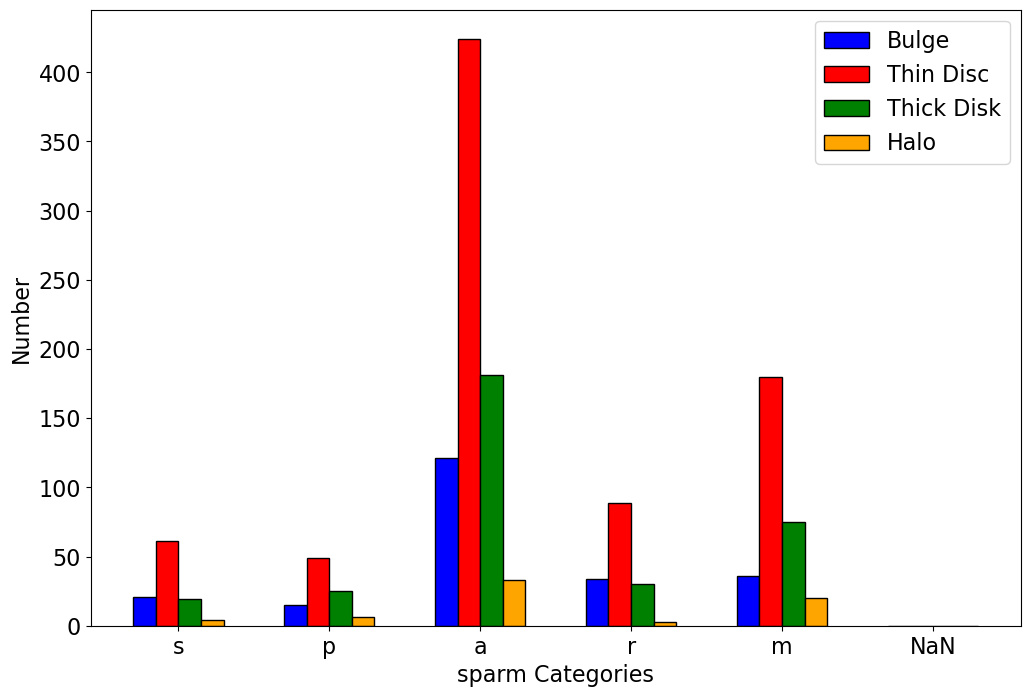

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Excel dosyasını oku
excel_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Disc_Region.xlsx"
df = pd.read_excel(excel_yolu, sheet_name='Maj_Angular_ERBIAS_SPARM')

# Kullanılacak sütunları seç
erbias_sutunu = df['SPARM']
gbilesen_sutunu = df['Gbileşen']

# '0' olan değerleri 'NaN' ile değiştir
erbias_sutunu.replace(0, np.nan, inplace=True)

# Kategori renklerini tanımla
renk_etiketleri = {
    'Bulge': 'blue',          # Bulge ise mavi
    'Thin Disc': 'red',       # Thin Disc ise kırmızı
    'Thick Disk': 'green',    # Thick Disk ise yeşil
    'Halo': 'orange',         # Halo ise turuncu
}

# E, R, B, İ, A, S kategorilerini ve NaN (eski 0) için histogram oluştur
categories = ['s', 'p', 'a', 'r', 'm', np.nan]
category_names = ['s', 'p', 'a', 'r', 'm', 'NaN']

# Histogramın genel özellikleri
bar_width = 0.15  # Her bir bileşen için sütun genişliği
x_positions = np.arange(len(categories))  # Her kategori için x eksenindeki pozisyonlar
offset = np.zeros_like(x_positions, dtype=float)  # Her kategori için başlangıçta kaydırma 0

plt.figure(figsize=(12, 8))

# Her bileşen için sütunları çiz
for component, color in renk_etiketleri.items():
    counts = []
    
    for category in categories:
        filtered_gbilesen_sutunu = gbilesen_sutunu[erbias_sutunu == category]
        component_count = filtered_gbilesen_sutunu[filtered_gbilesen_sutunu == component].count()
        counts.append(component_count)
    
    # Sütunları çiz
    plt.bar(x_positions + offset, counts, bar_width, color=color, edgecolor='black', label=component)
    offset += bar_width  # Sonraki bileşen için kaydırmayı artır

# X eksenini özelleştir
plt.xticks(x_positions + bar_width * 1.5, category_names)  # Kategorileri ortalamak için kaydırma
plt.xlabel('sparm Categories')
plt.ylabel('Number')
plt.legend(loc='upper right')

# Grafik dosyası yolunu belirle
save_path = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/sparm.png"
plt.savefig(save_path, bbox_inches='tight')

# Grafiği göster
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

# Excel dosyasını oku
excel_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Disc_Region.xlsx"
neat_result_df = pd.read_excel(excel_yolu, sheet_name='neat_result')
renklendirilmis_df = pd.read_excel(excel_yolu, sheet_name='Sayfa2')

# Renklendirme fonksiyonu
def get_color(component):
    if component == 'Bulge':
        return 'blue'
    elif component == 'Thin Disc':
        return 'red'
    elif component == 'Thick Disk':
        return 'green'
    elif component == 'Halo':
        return 'orange'
    else:
        return None

# Renklendirme bilgilerini ekle
renklendirilmis_df['color'] = renklendirilmis_df['Gbileşen'].apply(get_color)
renk_dict = renklendirilmis_df.set_index('idPNMain')['color'].to_dict()

# Histogramlar için klasör oluştur
klasor_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/histogramlar/ort/"
if not os.path.exists(klasor_yolu):
    os.makedirs(klasor_yolu)

# Histogram parametreleri
histogram_parametreleri = {
    'He/H': {'bins': 50, 'range': (0, 0.5)},
    'N/H': {'bins': 50, 'range': (0, 1e-3)},
    'O/H': {'bins': 50, 'range': (0, 3e-3)},
    'Ne/H': {'bins': 50, 'range': (0, 3e-3)},
    'S/H': {'bins': 50, 'range': (0, 3e-5)},
    'Cl/H': {'bins': 50, 'range': (0, 0.6e-5)},
    'Ar/H': {'bins': 50, 'range': (0, 175e-7)}
}

# Renklere karşılık gelen etiketler
renk_etiketleri = {
    'red': 'Thin Disc',
    'green': 'Thick Disc',
    'blue': 'Bulge',
    'orange': 'Halo'
}

# Söz konusu sütunlar
sütunlar = ['He/H', 'N/H', 'O/H', 'Ne/H', 'S/H', 'Cl/H', 'Ar/H']

# PDF dosyasının yolunu belirle
pdf_dosyasi_yolu = os.path.join(klasor_yolu, "total_elementsss.pdf")

# PDF dosyası oluştur
with PdfPages(pdf_dosyasi_yolu) as pdf:
    fig, axs = plt.subplots(4, 2, figsize=(12, 12))  # 3x3 grid
    axs = axs.flatten()

    # Histogramları oluştur ve ekle
    for i, başlık in enumerate(sütunlar):
        ax = axs[i]
        bins = histogram_parametreleri[başlık]['bins']
        range_ = histogram_parametreleri[başlık]['range']
        ortalamalar = {}

        for color, etiket in renk_etiketleri.items():
            filtreli_veri = neat_result_df[neat_result_df['idPNMain'].map(renk_dict) == color][başlık]
            filtreli_veri = filtreli_veri[(filtreli_veri != 0) & (filtreli_veri != 35000)]

            if not filtreli_veri.empty:
                ax.hist(filtreli_veri, bins=bins, range=range_, edgecolor='black', color=color, label=etiket)
                ortalama = filtreli_veri.mean()
                ortalamalar[etiket] = ortalama

        # Ortalama değerleri kesikli çizgilerle göster
        for etiket, ortalama in ortalamalar.items():
            if range_[0] <= ortalama <= range_[1]:
                color = [k for k, v in renk_etiketleri.items() if v == etiket][0]
                ax.axvline(ortalama, color=color, linestyle='dashed', linewidth=1)

        # Plot ayarları
        if başlık in ['c(Hb) (Ha/Hb)', 'c(Hb) (Hg/Hb)', 'c(Hb) (Hd/Hb)']:
            ax.set_xlabel("cH(β)")
        else:
            ax.set_xlabel(başlık)

        ax.set_ylabel("Number")
        ax.legend()

    # Boş olan alt grafikleri kaldır
    for j in range(len(sütunlar), len(axs)):
        fig.delaxes(axs[j])

    # 'Ar/H' histogramını ortada yerleştir
    axs[3], axs[1] = axs[1], axs[3]

    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

# Kontrol etmek için dosya yolu yazdır
if os.path.exists(pdf_dosyasi_yolu):
    print(f"PDF dosyası başarıyla kaydedildi: {pdf_dosyasi_yolu}")
else:
    print(f"PDF dosyası kaydedilemedi: {pdf_dosyasi_yolu}")

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

# Excel dosyasını oku
excel_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Disc_Region.xlsx"
neat_result_df = pd.read_excel(excel_yolu, sheet_name='Sayfa4')
renklendirilmis_df = pd.read_excel(excel_yolu, sheet_name='Sayfa5')

# Renklendirme fonksiyonu
def get_color(component):
    if component == 'Bulge':
        return 'blue'
    elif component == 'Thin Disc':
        return 'red'
    elif component == 'Thick Disk':
        return 'green'
    elif component == 'Halo':
        return 'orange'
    else:
        return None

# Renklendirme bilgilerini ekle
renklendirilmis_df['color'] = renklendirilmis_df['Gbileşen'].apply(get_color)
renk_dict = renklendirilmis_df.set_index('idPNMain')['color'].to_dict()

# Histogramlar için klasör oluştur
klasor_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/histogramlar/ort/"
if not os.path.exists(klasor_yolu):
    os.makedirs(klasor_yolu)

# Histogram parametreleri
histogram_parametreleri = {
    'He/H': {'bins': 50},
    'N/H': {'bins': 50},
    'O/H': {'bins': 50},
    'Ne/H': {'bins': 50},
    'S/H': {'bins': 50},
    'Cl/H': {'bins': 50},
    'Ar/H': {'bins': 50}
}

# Renklere karşılık gelen etiketler ve sıralama
renk_etiketleri = {
    'blue': 'Bulge',
    'red': 'Thin Disc',
    'green': 'Thick Disk',
    'orange': 'Halo'
}

# Söz konusu sütunlar
sütunlar = ['He/H', 'N/H', 'O/H', 'Ne/H', 'S/H', 'Cl/H', 'Ar/H']

# PDF dosyasının yolunu belirle
pdf_dosyasi_yolu = os.path.join(klasor_yolu, "total_element.pdf")

# PDF dosyası oluştur
with PdfPages(pdf_dosyasi_yolu) as pdf:
    fig, axs = plt.subplots(4, 2, figsize=(12, 12))  # 4x2 grid
    axs = axs.flatten()

    # Histogramları oluştur ve ekle
    for i, başlık in enumerate(sütunlar):
        ax = axs[i]
        bins = histogram_parametreleri[başlık]['bins']
        range_ = (neat_result_df[başlık].min(), neat_result_df[başlık].max())
        ortalamalar = {}

        # Kategoriler ve renkler
        kategori_renkleri = {'blue': 'Bulge', 'red': 'Thin Disc', 'green': 'Thick Disk', 'orange': 'Halo'}

        # Kategorilere göre histogramları çiz
        for color in kategori_renkleri.keys():
            etiket = kategori_renkleri[color]
            filtreli_veri = neat_result_df[neat_result_df['idPNMain'].map(renk_dict) == color][başlık]
            filtreli_veri = filtreli_veri[(filtreli_veri != 0) & (filtreli_veri != '#SAYI!')]

            if not filtreli_veri.empty:
                ax.hist(filtreli_veri, bins=bins, range=range_, edgecolor='black', color=color, label=etiket)
                ortalama = filtreli_veri.mean()
                ortalamalar[etiket] = ortalama

        # Ortalama değerleri kesikli çizgilerle göster
        for etiket, ortalama in ortalamalar.items():
            if range_[0] <= ortalama <= range_[1]:
                color = [k for k, v in kategori_renkleri.items() if v == etiket][0]
                ax.axvline(ortalama, color=color, linestyle='dashed', linewidth=1)

        # Genel ortalamayı hesapla ve siyah kesikli çizgi ile göster
        genel_filtreli_veri = neat_result_df[başlık]
        genel_filtreli_veri = genel_filtreli_veri[(genel_filtreli_veri != 0)]
        genel_ortalama = genel_filtreli_veri.mean()

        if range_[0] <= genel_ortalama <= range_[1]:
            ax.axvline(genel_ortalama, color='black', linestyle='dashed', linewidth=1)

        # Plot ayarları
        ax.set_xlabel(başlık, fontsize=14)
        ax.set_ylabel("Number", fontsize=14)
        # Legend sıralaması
        legend_labels = ['Bulge', 'Thin Disc', 'Thick Disk', 'Halo']
        ax.legend(legend_labels, fontsize=8)

    # Boş olan alt grafikleri kaldır
    for j in range(len(sütunlar), len(axs)):
        fig.delaxes(axs[j])

    # 'Ar/H' histogramını ortada yerleştir
    axs[3], axs[1] = axs[1], axs[3]

    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

# Kontrol etmek için dosya yolu yazdır
if os.path.exists(pdf_dosyasi_yolu):
    print(f"PDF dosyası başarıyla kaydedildi: {pdf_dosyasi_yolu}")
else:
    print(f"PDF dosyası kaydedilemedi: {pdf_dosyasi_yolu}")
    #print(f"Bulge verisi sayısı: {len(neat_result_df[neat_result_df['idPNMain'].map(renk_dict) == 'blue'][başlık])}")

PDF dosyası başarıyla kaydedildi: /Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/histogramlar/ort/total_element.pdf


In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

# Excel dosyasını oku
excel_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Disc_Region.xlsx"
neat_result_df = pd.read_excel(excel_yolu, sheet_name='Sayfa4')
renklendirilmis_df = pd.read_excel(excel_yolu, sheet_name='Sayfa5')

# Renklendirme fonksiyonu
def get_color(component):
    if component == 'Bulge':
        return 'blue'
    elif component == 'Thin Disc':
        return 'red'
    elif component == 'Thick Disk':
        return 'green'
    elif component == 'Halo':
        return 'orange'
    else:
        return None

# Renklendirme bilgilerini ekle
renklendirilmis_df['color'] = renklendirilmis_df['Gbileşen'].apply(get_color)
renk_dict = renklendirilmis_df.set_index('idPNMain')['color'].to_dict()

# Histogramlar için klasör oluştur
klasor_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/histogramlar/ort/"
if not os.path.exists(klasor_yolu):
    os.makedirs(klasor_yolu)

# Histogram parametreleri
histogram_parametreleri = {
    'He/H': {'bins': 50},
    'N/H': {'bins': 50},
    'O/H': {'bins': 50},
    'Ne/H': {'bins': 50},
    'S/H': {'bins': 50},
    'Cl/H': {'bins': 50},
    'Ar/H': {'bins': 50}
}

# Renklere karşılık gelen etiketler ve sıralama
renk_etiketleri = {
    'blue': 'Bulge',
    'red': 'Thin Disc',
    'green': 'Thick Disk',
    'orange': 'Halo'
}

# Söz konusu sütunlar
sütunlar = ['He/H', 'N/H', 'O/H', 'Ne/H', 'S/H', 'Cl/H', 'Ar/H']

# PDF dosyasının yolunu belirle
pdf_dosyasi_yolu = os.path.join(klasor_yolu, "total_elementt.pdf")

# PDF dosyası oluştur
with PdfPages(pdf_dosyasi_yolu) as pdf:
    fig, axs = plt.subplots(len(sütunlar), len(renk_etiketleri), figsize=(15, 20))  # 7x4 grid
    axs = axs.flatten()

    # Histogramları oluştur ve ekle
    for i, başlık in enumerate(sütunlar):
        for j, (color, etiket) in enumerate(renk_etiketleri.items()):
            ax = axs[i * len(renk_etiketleri) + j]
            bins = histogram_parametreleri[başlık]['bins']
            range_ = (neat_result_df[başlık].min(), neat_result_df[başlık].max())
            filtreli_veri = neat_result_df[neat_result_df['idPNMain'].map(renk_dict) == color][başlık]
            filtreli_veri = filtreli_veri[(filtreli_veri != 0) & (filtreli_veri != '#SAYI!')]

            if not filtreli_veri.empty:
                ax.hist(filtreli_veri, bins=bins, range=range_, edgecolor='black', color=color, label=etiket)
                ortalama = filtreli_veri.mean()
                medyan = filtreli_veri.median()

                # Ortalama ve medyan çizgileri
                if range_[0] <= ortalama <= range_[1]:
                    ax.axvline(ortalama, color=color, linestyle='dashed', linewidth=1, label=f'{etiket} Mean')
                if range_[0] <= medyan <= range_[1]:
                    ax.axvline(medyan, color='black', linestyle='dashed', linewidth=1, label='Median')

                # Plot ayarları
                ax.set_xlabel(başlık, fontsize=10)
                ax.set_ylabel("Number", fontsize=10)
                #ax.legend(fontsize=8)

    # Boş olan alt grafikleri kaldır
    for j in range(len(sütunlar) * len(renk_etiketleri), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

# Kontrol etmek için dosya yolu yazdır
if os.path.exists(pdf_dosyasi_yolu):
    print(f"PDF dosyası başarıyla kaydedildi: {pdf_dosyasi_yolu}")
else:
    print(f"PDF dosyası kaydedilemedi: {pdf_dosyasi_yolu}")

PDF dosyası başarıyla kaydedildi: /Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/histogramlar/ort/total_elementt.pdf


In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

# Excel dosyasını oku
excel_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Disc_Region.xlsx"
neat_result_df = pd.read_excel(excel_yolu, sheet_name='neat_result')
renklendirilmis_df = pd.read_excel(excel_yolu, sheet_name='Sayfa2')

# Renklendirme fonksiyonu
def get_color(component):
    if component == 'Bulge':
        return 'blue'
    elif component == 'Thin Disc':
        return 'red'
    elif component == 'Thick Disk':
        return 'green'
    elif component == 'Halo':
        return 'orange'
    else:
        return None

# Renklendirme bilgilerini ekle
renklendirilmis_df['color'] = renklendirilmis_df['Gbileşen'].apply(get_color)
renk_dict = renklendirilmis_df.set_index('idPNMain')['color'].to_dict()

# Histogramlar için klasör oluştur
klasor_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/histogramlar/ort/"
if not os.path.exists(klasor_yolu):
    os.makedirs(klasor_yolu)

# Histogram parametreleri
histogram_parametreleri = {
    '[O III] Temperature': {'bins': 50, 'range': (5000, 35000)},
    '[N II] temperature': {'bins': 100, 'range': (5000, 35000)},
    '[S II] Density': {'bins': 50, 'range': (0, 15000)}
}

# Renklere karşılık gelen etiketler ve sıralama
renk_etiketleri = {
    'blue': 'Bulge',
    'red': 'Thin Disc',
    'green': 'Thick Disk',
    'orange': 'Halo'
}

# Legend sıralaması
legend_sıralaması = ['Bulge', 'Thin Disc', 'Thick Disk', 'Halo']

# Söz konusu sütunlar
sütunlar = ['[S II] Density', '[O III] Temperature', '[N II] temperature']

# PDF dosyasının yolunu belirle
pdf_dosyasi_yolu = os.path.join(klasor_yolu, "Te_Ne.pdf")

# PDF dosyası oluştur
with PdfPages(pdf_dosyasi_yolu) as pdf:
    fig, axs = plt.subplots(3, 1, figsize=(12, 12))
    axs = axs.flatten()

    # Histogramları oluştur ve ekle
    for i, başlık in enumerate(sütunlar):
        ax = axs[i]
        bins = histogram_parametreleri[başlık]['bins']
        range_ = histogram_parametreleri[başlık]['range']
        ortalamalar = {}

        # Genel ortalamayı hesapla (0 ve 35000 dışındaki değerler)
        genel_veri = neat_result_df[başlık]
        genel_veri = genel_veri[(genel_veri != 0) & (genel_veri != 35000)]
        genel_ortalama = genel_veri.mean()

        # Renk bazlı ortalamaları hesapla
        for color, etiket in renk_etiketleri.items():
            filtreli_veri = neat_result_df[neat_result_df['idPNMain'].map(renk_dict) == color][başlık]
            filtreli_veri = filtreli_veri[(filtreli_veri != 0) & (filtreli_veri != 35000)]

            if not filtreli_veri.empty:
                ax.hist(filtreli_veri, bins=bins, range=range_, edgecolor='black', color=color, label=etiket)
                ortalama = filtreli_veri.mean()
                ortalamalar[etiket] = ortalama

        # Ortalama değerleri kesikli çizgilerle göster
        for etiket, ortalama in ortalamalar.items():
            if range_[0] <= ortalama <= range_[1]:
                color = [k for k, v in renk_etiketleri.items() if v == etiket][0]
                ax.axvline(ortalama, color=color, linestyle='dashed', linewidth=1)

        # Genel ortalamayı siyah kesikli çizgi ile göster
        if range_[0] <= genel_ortalama <= range_[1]:
            ax.axvline(genel_ortalama, color='black', linestyle='dashed', linewidth=1)

        # Plot ayarları
        ax.set_xlabel(başlık, fontsize=20)
        ax.set_ylabel("Number", fontsize=20)

        # Legend sıralamasını ayarla
        handles, labels = ax.get_legend_handles_labels()
        sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: legend_sıralaması.index(x[1]))
        handles, labels = zip(*sorted_handles_labels)
        ax.legend(handles, labels, fontsize=14)

    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

# Kontrol etmek için dosya yolu yazdır
if os.path.exists(pdf_dosyasi_yolu):
    print(f"PDF dosyası başarıyla kaydedildi: {pdf_dosyasi_yolu}")
else:
    print(f"PDF dosyası kaydedilemedi: {pdf_dosyasi_yolu}")


PDF dosyası başarıyla kaydedildi: /Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/histogramlar/ort/Te_Ne.pdf


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import os

# Excel dosyasını oku
excel_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Disc_Region.xlsx"
df = pd.read_excel(excel_yolu, sheet_name='düşeyara')

# ERBIAS ve SPARM sütunlarını seç
erbias_sutunu = df['ERBIAS']
sparm_sutunu = df['SPARM']
gbilesen_sutunu = df['Gbileşen']

# '0' olan değerleri 'NaN' ile değiştir
erbias_sutunu.replace(0, np.nan, inplace=True)
sparm_sutunu.replace(0, np.nan, inplace=True)

# Kategori renklerini tanımla
renk_etiketleri = {
    'Bulge': 'blue',          # Bulge ise mavi
    'Thin Disc': 'red',       # Thin Disc ise kırmızı
    'Thick Disc': 'green',    # Thick Disk ise yeşil
    'Halo': 'orange',         # Halo ise turuncu
}

# Histogramın genel özellikleri
bar_width = 0.15  # Her bir bileşen için sütun genişliği

# ERBIAS histogramını oluşturacak fonksiyon
def plot_erbias_histogram(ax):
    categories = ['E', 'R', 'B', 'I', 'A', 'S']#, np.nan]
    category_names = ['E', 'R', 'B', 'I', 'A', 'S']#, 'NaN']
    x_positions = np.arange(len(categories))  # Her kategori için x eksenindeki pozisyonlar
    offset = np.zeros_like(x_positions, dtype=float)  # Her kategori için başlangıçta kaydırma 0

    for component, color in renk_etiketleri.items():
        counts = []

        for category in categories:
            filtered_gbilesen_sutunu = gbilesen_sutunu[erbias_sutunu == category]
            component_count = filtered_gbilesen_sutunu[filtered_gbilesen_sutunu == component].count()
            counts.append(component_count)

        # Sütunları çiz
        ax.bar(x_positions + offset, counts, bar_width, color=color, edgecolor='black', label=component)
        offset += bar_width  # Sonraki bileşen için kaydırmayı artır

    # X eksenini özelleştir
    ax.set_xticks(x_positions + bar_width * 1.5)
    ax.set_xticklabels(category_names)
    ax.set_xlabel('ERBIAS Categories')
    ax.set_ylabel('Number')
    #ax.legend(loc='upper right')

# SPARM histogramını oluşturacak fonksiyon
def plot_sparm_histogram(ax):
    categoriess = ['s', 'p', 'a', 'r', 'm']#, np.nan]
    category_namess = ['s', 'p', 'a', 'r', 'm']#, 'NaN']
    x_positions = np.arange(len(categoriess))  # Her kategori için x eksenindeki pozisyonlar
    offset = np.zeros_like(x_positions, dtype=float)  # Her kategori için başlangıçta kaydırma 0

    for component, color in renk_etiketleri.items():
        counts = []

        for category in categoriess:
            filtered_gbilesen_sutunu = gbilesen_sutunu[sparm_sutunu == category]
            component_count = filtered_gbilesen_sutunu[filtered_gbilesen_sutunu == component].count()
            counts.append(component_count)

        # Sütunları çiz
        ax.bar(x_positions + offset, counts, bar_width, color=color, edgecolor='black', label=component)
        offset += bar_width  # Sonraki bileşen için kaydırmayı artır

    # X eksenini özelleştir
    ax.set_xticks(x_positions + bar_width * 1.5)
    ax.set_xticklabels(category_namess)
    ax.set_xlabel('SPARM Categories')
    ax.set_ylabel('Number')
    #ax.legend(loc='upper right')

# Diğer histogramları oluşturacak fonksiyonlar
# Bileşenleri istenen sırada tanımla
renk_etiketleri = {
    
    
    
    'Thin Disc': 'red',       # En son Thin Disc
    'Thick Disc': 'green',    # Daha sonra Thick Disk
    'Bulge': 'blue',          # Sonra Bulge
    'Halo': 'orange',         # Önce Halo
}

# Histogramları oluşturacak fonksiyonları güncelle
def plot_histogram(ax, veri_sutunu, gbilesen_sutunu, bins, title, xlabel, ylabel):
    veri_sutunu = pd.to_numeric(veri_sutunu, errors='coerce')
    filtered_df = df[veri_sutunu <= bins[-1]]
    filtered_veri_sutunu = filtered_df[veri_sutunu.name]
    filtered_gbilesen_sutunu = filtered_df[gbilesen_sutunu.name]

    hist_data = []
    ortalama_degerler = {}

    # Bileşenleri belirli bir sırayla döngüye al
    for component, color in renk_etiketleri.items():
        component_values = filtered_veri_sutunu[filtered_gbilesen_sutunu == component]
        counts, bins = np.histogram(component_values, bins=bins)
        hist_data.append((component, counts, bins, color))
        mean_value = component_values.mean()
        ortalama_degerler[component] = mean_value

    # Histogramları çizim sırasına göre çiz
    for component, counts, bins, color in hist_data:
        ax.hist(bins[:-1], bins=bins, weights=counts, color=color, edgecolor='black', label=component)
        mean_value = ortalama_degerler[component]
        ax.axvline(x=mean_value, color=color, linestyle='--', label=f'{component} Mean')

    # Genel ortalamayı gösteren siyah bir çizgi ekle
    all_mean_value = filtered_veri_sutunu.mean()
    ax.axvline(x=all_mean_value, color='black', linestyle='--', label='All PNe')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

# PDF dosyasının yolunu belirle
pdf_dosyasi_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/histogramlar/HASH_Size_Morfo.pdf"

# PDF dosyası oluştur
with PdfPages(pdf_dosyasi_yolu) as pdf:
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))  # 2x2 grid
    axs = axs.flatten()

    # Histogramları oluştur
    plot_histogram(axs[0], df['MajDiam'], df['Gbileşen'], np.arange(0, 201, 2), 'Diameter Histogram', 'Diameter (′′)', 'Number')
    plot_histogram(axs[1], df['Açısal_genişlik'], df['Gbileşen'], np.arange(0, 4, 0.1), 'Angular Width Histogram', 'Angular Width (pc)', 'Number')
    plot_erbias_histogram(axs[2])
    plot_sparm_histogram(axs[3])

    plt.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

# Kontrol etmek için dosya yolu yazdır
if os.path.exists(pdf_dosyasi_yolu):
    print(f"PDF dosyası başarıyla kaydedildi: {pdf_dosyasi_yolu}")
else:
    print(f"PDF dosyası kaydedilemedi: {pdf_dosyasi_yolu}")

PDF dosyası başarıyla kaydedildi: /Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/histogramlar/HASH_Size_Morfo.pdf


c(Hb) (Ha/Hb) - Tüm Veriler Medyanı (0 hariç): 1.34e+00
c(Hb) (Ha/Hb) - Thin Disc Medyan (0 hariç): 1.54e+00
c(Hb) (Ha/Hb) - Thick Disc Medyan (0 hariç): 9.25e-01
c(Hb) (Ha/Hb) - Bulge Medyan (0 hariç): 1.67e+00
c(Hb) (Ha/Hb) - Halo Medyan (0 hariç): 4.64e-01
c(Hb) (Hg/Hb) - Tüm Veriler Medyanı (0 hariç): 3.15e+00
c(Hb) (Hg/Hb) - Thin Disc Medyan (0 hariç): 3.02e+00
c(Hb) (Hg/Hb) - Thick Disc Medyan (0 hariç): 1.93e+00
c(Hb) (Hg/Hb) - Bulge Medyan (0 hariç): 3.58e+00
c(Hb) (Hg/Hb) - Halo Medyan (0 hariç): 2.46e+00
c(Hb) (Hd/Hb) - Tüm Veriler Medyanı (0 hariç): 1.50e+00
c(Hb) (Hd/Hb) - Thin Disc Medyan (0 hariç): 1.52e+00
c(Hb) (Hd/Hb) - Thick Disc Medyan (0 hariç): 1.17e+00
c(Hb) (Hd/Hb) - Bulge Medyan (0 hariç): 2.12e+00
c(Hb) (Hd/Hb) - Halo Medyan (0 hariç): 9.19e-01
[OII] density - Tüm Veriler Medyanı (0 hariç): 5.90e+02
[OII] density - Thin Disc Medyan (0 hariç): 5.40e+02
[OII] density - Thick Disc Medyan (0 hariç): 2.14e+02
[OII] density - Bulge Medyan (0 hariç): 2.13e+01
[OII] de

/var/folders/ry/6rcrw5vs4f33lx3wyt4f6m5w0000gn/T/ipykernel_2077/2536717143.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Cl/H - Tüm Veriler Medyanı (0 hariç): 5.74e-07
Cl/H - Thin Disc Medyan (0 hariç): 6.96e-07
Cl/H - Thick Disc Medyan (0 hariç): 4.56e-07
Cl/H - Bulge Medyan (0 hariç): 5.59e-07
Cl/H - Halo Medyan (0 hariç): 2.04e-07
He/H - Tüm Veriler Medyanı (0 hariç): 2.02e-01
He/H - Thin Disc Medyan (0 hariç): 2.18e-01
He/H - Thick Disc Medyan (0 hariç): 1.73e-01
He/H - Bulge Medyan (0 hariç): 2.18e-01
He/H - Halo Medyan (0 hariç): 1.21e-01
Diameter - Tüm Veriler Medyanı (0 hariç): 1.50e+01
Diameter - Thin Disc Medyan (0 hariç): 1.56e+01
Diameter - Thick Disc Medyan (0 hariç): 1.91e+01
Diameter - Bulge Medyan (0 hariç): 1.00e+01
Diameter - Halo Medyan (0 hariç): 1.58e+01
Angular Width - Tüm Veriler Medyanı (0 hariç): 3.36e-01
Angular Width - Thin Disc Medyan (0 hariç): 2.98e-01
Angular Width - Thick Disc Medyan (0 hariç): 4.62e-01
Angular Width - Bulge Medyan (0 hariç): 3.58e-01
Angular Width - Halo Medyan (0 hariç): 4.01e-01
Histogramlar başarıyla oluşturuldu ve medyanlar listeye yazıldı.


/var/folders/ry/6rcrw5vs4f33lx3wyt4f6m5w0000gn/T/ipykernel_2077/2536717143.py:223: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  with PdfPages(pdf_dosyasi_yolu) as pdf:


ValueError: 'Thin Disc' is not a valid color value.

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

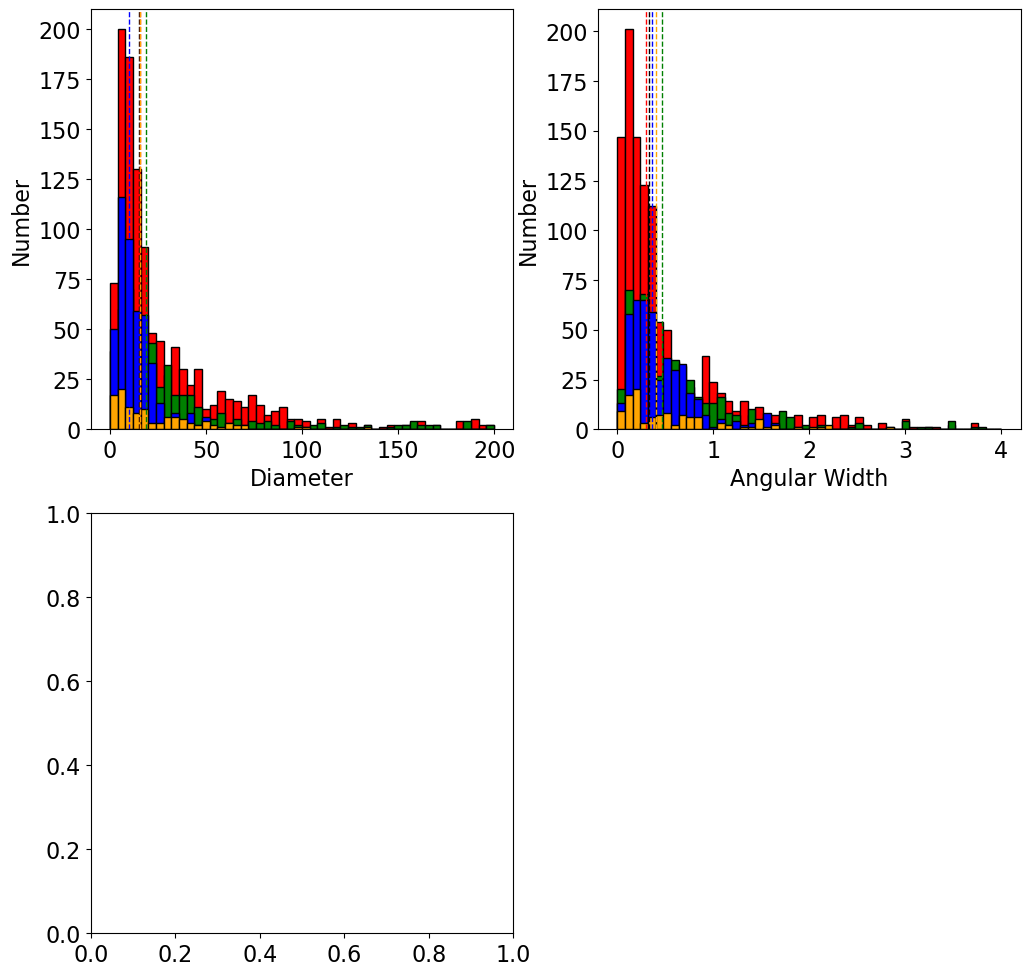

In [164]:
#### ORTALAMA YERİNE MEDİAN DEĞERİ SİYAH KESİKLİ ÇİZGİ İLE GÖSTERİLİYOR ####

#### Te, Ne ve element bollukları log alınmış değerleri ile histogram oluşturarak tek bir pdf dosyasında birleştiriyor. ####

import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

# Excel dosyasını oku
excel_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/Disc_Region.xlsx"
neat_result_df = pd.read_excel(excel_yolu, sheet_name='neat_result')
renklendirilmis_df = pd.read_excel(excel_yolu, sheet_name='Sayfa2')

# Histogramlar için klasör oluştur
klasor_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/histogramlar/"
if not os.path.exists(klasor_yolu):
    os.makedirs(klasor_yolu)

# Ortalamalar için dosya oluştur
ortalama_dosyasi_yolu = os.path.join(klasor_yolu, "ortalama_degerler.txt")

# Renklendirme fonksiyonu
def get_color(component):
    if component == 'Bulge':
        return 'blue'
    elif component == 'Thin Disc':
        return 'red'
    elif component == 'Thick Disc':
        return 'green'
    elif component == 'Halo':
        return 'orange'
    else:
        return None

# Renklendirme bilgilerini ekle
renklendirilmis_df['color'] = renklendirilmis_df['Gbileşen'].apply(get_color)
renk_dict = renklendirilmis_df.set_index('idPNMain')['color'].to_dict()

# Sütun başlıkları
sutun_basliklari = ['c(Hb) (Ha/Hb)', 'c(Hb) (Hg/Hb)', 'c(Hb) (Hd/Hb)', '[OII] density', '[S II] Density', '[ArIV] density', 
                    '[OII] temperature', '[S II] temperature', '[N II] temperature', 
                    '[OI] temperature', '[O III] Temperature', '[NeIII] temperature', 
                    '[ArIII] temperature', '[ArV] temperature', 'He I temperature (7281/6678)', 
                    'C/H', 'N/H', 'O/H', 'Ne/H', 'Ar/H', 'S/H', 'Cl/H', 'He/H', 'Diameter', 'Angular Width']

# Histogram parametreleri
histogram_parametreleri = {
    'c(Hb) (Ha/Hb)': {'bins': 50, 'range': (0, 6)},
    'c(Hb) (Hg/Hb)': {'bins': 50, 'range': (0, 6)},
    'c(Hb) (Hd/Hb)': {'bins': 50, 'range': (0, 6)},
    '[OII] density': {'bins': 50, 'range': (0, 20000)},
    '[S II] Density': {'bins': 50, 'range': (0, 15000)},
    '[ArIV] density': {'bins': 50, 'range': (0, 70000)},
    '[OII] temperature': {'bins': 50, 'range': (5000, 35000)},
    '[S II] temperature': {'bins': 50, 'range': (0, 35000)},
    '[N II] temperature': {'bins': 50, 'range': (5000, 35000)},
    '[OI] temperature': {'bins': 50, 'range': (0, 35000)},
    '[O III] Temperature': {'bins': 50, 'range': (5000, 35000)},
    '[NeIII] temperature': {'bins': 50, 'range': (0, 35000)},
    '[ArIII] temperature': {'bins': 50, 'range': (5000, 35000)},
    '[ArV] temperature': {'bins': 50, 'range': (0, 35000)},
    'He I temperature (7281/6678)': {'bins': 50, 'range': (0, 4e5)},
    'C/H': {'bins': 50, 'range': (0, 1e-3)},
    'N/H': {'bins': 50, 'range': (0, 1e-3)},
    'O/H': {'bins': 50, 'range': (0, 3e-3)},
    'Ne/H': {'bins': 50, 'range': (0, 3e-3)},
    'Ar/H': {'bins': 50, 'range': (0, 175e-7)},
    'S/H': {'bins': 50, 'range': (0, 3e-5)},
    'Cl/H': {'bins': 50, 'range': (0, 0.6e-5)},
    'He/H': {'bins': 50, 'range': (0, 0.5)},
    'Diameter': {'bins': 50, 'range': (0, 200)},
    'Angular Width': {'bins': 50, 'range': (0, 4)}
}

# Renklere karşılık gelen etiketler
renk_etiketleri = {
    'red': 'Thin Disc',
    'green': 'Thick Disc',
    'blue': 'Bulge',
    'orange': 'Halo'
}

# Ortalamaları yazmak için dosyayı aç
with open(ortalama_dosyasi_yolu, 'w') as f:
    # Her sütun için histogram oluştur
    for baslik in sutun_basliklari:
        plt.figure()
        bins = histogram_parametreleri[baslik]['bins']
        range_ = histogram_parametreleri[baslik]['range']
        ortalamalar = {}
        
        # 0 değerleri hariç tutarak tüm verilerin medyanını hesapla ve siyah kesikli çizgi olarak göster
        tum_veriler_median = neat_result_df[baslik][neat_result_df[baslik] != 0].median()
        plt.axvline(tum_veriler_median, color='black', linestyle='dashed', linewidth=1)
        print(f"{baslik} - Tüm Veriler Medyanı (0 hariç): {tum_veriler_median:.2e}")
        f.write(f"{baslik} - Tüm Veriler Medyanı (0 hariç): {tum_veriler_median:.2e}\n")
        
        for color, etiket in renk_etiketleri.items():
            filtreli_veri = neat_result_df[neat_result_df['idPNMain'].map(renk_dict) == color][baslik]
            filtreli_veri = filtreli_veri[(filtreli_veri != 0) & (filtreli_veri != 35000)]
            
            if not filtreli_veri.empty:
                plt.hist(filtreli_veri, bins=bins, range=range_, edgecolor='black', color=color, label=etiket)
                medyan = filtreli_veri.median()
                ortalamalar[etiket] = medyan
        
        # Medyan değerleri kesikli çizgilerle göster
        for etiket, medyan in ortalamalar.items():
            color = [k for k, v in renk_etiketleri.items() if v == etiket][0]
            plt.axvline(medyan, color=color, linestyle='dashed', linewidth=1)
            print(f"{baslik} - {etiket} Medyan (0 hariç): {medyan:.2e}")
            f.write(f"{baslik} - {etiket} Medyan (0 hariç): {medyan:.2e}\n")
        
        # Plot ayarları
        if baslik in ['c(Hb) (Ha/Hb)', 'c(Hb) (Hg/Hb)', 'c(Hb) (Hd/Hb)']:
            plt.xlabel("cH(β)")
        else:
            plt.xlabel(baslik)
        
        plt.ylabel("Number")
        #plt.legend(fontsize=12)
        
        # Histogramı kaydet
        kaydet_yolu = os.path.join(klasor_yolu, f"{baslik.replace('/', '_')}.png")
        plt.savefig(kaydet_yolu, dpi=300)
        
        # Plot'u temizle
        plt.clf()

print("Histogramlar başarıyla oluşturuldu ve medyanlar listeye yazıldı.")

# PDF dosyası yolu
pdf_dosyasi_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/histogramlar/selected_histograms.pdf"

# Histogram başlıkları
basliklar = ['[S II] Density', '[N II] temperature', '[O III] Temperature']

# PDF ile grafik oluşturma
with PdfPages(pdf_dosyasi_yolu) as pdf:
    plt.figure(figsize=(12, 12))  # Şekil boyutunu ayarlayın

    for i, baslik in enumerate(basliklar):
        plt.subplot(len(basliklar), 1, i + 1)  # 1 satır, len(basliklar) sütunlu alt grafikleri oluşturur
        bins = histogram_parametreleri[baslik]['bins']
        range_ = histogram_parametreleri[baslik]['range']
        ortalamalar = {}
        
        # 0 değerleri hariç tutarak tüm verilerin medyanını hesapla ve siyah kesikli çizgi olarak göster
        tum_veriler_median = neat_result_df[baslik][neat_result_df[baslik] != 0].median()
        plt.axvline(tum_veriler_median, color='black', linestyle='dashed', linewidth=1)
        
        for color, etiket in renk_etiketleri.items():
            filtreli_veri = neat_result_df[neat_result_df['idPNMain'].map(renk_dict) == color][baslik]
            filtreli_veri = filtreli_veri[(filtreli_veri != 0) & (filtreli_veri != 35000)]
            
            if not filtreli_veri.empty:
                plt.hist(filtreli_veri, bins=bins, range=range_, edgecolor='black', color=color, label=etiket)
                medyan = filtreli_veri.median()
                ortalamalar[etiket] = medyan
        
        for etiket, medyan in ortalamalar.items():
            color = [k for k, v in renk_etiketleri.items() if v == etiket][0]
            plt.axvline(medyan, color=color, linestyle='dashed', linewidth=1)
        
        plt.xlabel(baslik)
        plt.ylabel("Number")
        #plt.legend(fontsize=12)
        plt.tight_layout()  # Alt grafiklerin sıkışmaması için düzenler

    pdf.savefig()  # Tek bir sayfaya tüm alt grafiklerle birlikte kaydeder
    plt.clf()
    
# PDF dosyası yolu
pdf_dosyasi_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/histogramlar/selected_histograms.pdf"

# Histogram başlıkları
basliklar = ['[S II] Density', '[N II] temperature', '[O III] Temperature']

# PDF ile grafik oluşturma
with PdfPages(pdf_dosyasi_yolu) as pdf:
    plt.figure(figsize=(12, 12))  # Şekil boyutunu ayarlayın

    for i, baslik in enumerate(basliklar):
        plt.subplot(len(basliklar), 1, i + 1)  # 1 satır, len(basliklar) sütunlu alt grafikleri oluşturur
        bins = histogram_parametreleri[baslik]['bins']
        range_ = histogram_parametreleri[baslik]['range']
        ortalamalar = {}
        
        # 0 değerleri hariç tutarak tüm verilerin medyanını hesapla ve siyah kesikli çizgi olarak göster
        tum_veriler_median = neat_result_df[baslik][neat_result_df[baslik] != 0].median()
        plt.axvline(tum_veriler_median, color='black', linestyle='dashed', linewidth=1)
        
        for color, etiket in renk_etiketleri.items():
            filtreli_veri = neat_result_df[neat_result_df['idPNMain'].map(renk_dict) == color][baslik]
            filtreli_veri = filtreli_veri[(filtreli_veri != 0) & (filtreli_veri != 35000)]
            
            if not filtreli_veri.empty:
                plt.hist(filtreli_veri, bins=bins, range=range_, edgecolor='black', color=color, label=etiket)
                medyan = filtreli_veri.median()
                ortalamalar[etiket] = medyan
        
        for etiket, medyan in ortalamalar.items():
            color = [k for k, v in renk_etiketleri.items() if v == etiket][0]
            plt.axvline(medyan, color=color, linestyle='dashed', linewidth=1)
        
        plt.xlabel(baslik)
        plt.ylabel("Number")
        #plt.legend(fontsize=12)
        plt.tight_layout()  # Alt grafiklerin sıkışmaması için düzenler

    pdf.savefig()  # Tek bir sayfaya tüm alt grafiklerle birlikte kaydeder
    plt.clf()

    
# PDF dosyası yolu
pdf_dosyasi_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/histogramlar/size_histograms.pdf"

# Histogram başlıkları
basliklar = ['Diameter', 'Angular Width']

# PDF ile grafik oluşturma
with PdfPages(pdf_dosyasi_yolu) as pdf:
    plt.figure(figsize=(12, 12))  # Şekil boyutunu ayarlayın (genişlik, yükseklik)

    # Histogramlar için alt grafikler
    for i, baslik in enumerate(basliklar):
        plt.subplot(2, 2, i + 1)  # 2 satır, 2 sütunlu alt grafikleri oluşturur
        bins = histogram_parametreleri[baslik]['bins']
        range_ = histogram_parametreleri[baslik]['range']
        ortalamalar = {}
        
        # 0 değerleri hariç tutarak tüm verilerin medyanını hesapla ve siyah kesikli çizgi olarak göster
        tum_veriler_median = neat_result_df[baslik][neat_result_df[baslik] != 0].median()
        plt.axvline(tum_veriler_median, color='black', linestyle='dashed', linewidth=1)
        
        for color, etiket in renk_etiketleri.items():
            filtreli_veri = neat_result_df[neat_result_df['idPNMain'].map(renk_dict) == color][baslik]
            filtreli_veri = filtreli_veri[(filtreli_veri != 0) & (filtreli_veri != 35000)]
            
            if not filtreli_veri.empty:
                plt.hist(filtreli_veri, bins=bins, range=range_, edgecolor='black', color=color, label=etiket)
                medyan = filtreli_veri.median()
                ortalamalar[etiket] = medyan
        
        for etiket, medyan in ortalamalar.items():
            color = [k for k, v in renk_etiketleri.items() if v == etiket][0]
            plt.axvline(medyan, color=color, linestyle='dashed', linewidth=1)
        
        plt.xlabel(baslik)
        plt.ylabel("Number")
        #plt.legend(fontsize=12)
    
    # ERBIAS histogramı (3. grafik, 2. satır 1. sütun)
    ax1 = plt.subplot(2, 2, 3)
    plot_erbias_histogram(ax1)

    # SPARM histogramı (4. grafik, 2. satır 2. sütun)
    ax2 = plt.subplot(2, 2, 4)
    plot_sparm_histogram(ax2)

    plt.tight_layout()  # Alt grafiklerin sıkışmaması için düzenler
    pdf.savefig()  # Tek bir sayfaya tüm alt grafiklerle birlikte kaydeder
    plt.clf()  # Şekli temizler

# ERBIAS histogramı oluşturma fonksiyonu
def plot_erbias_histogram(ax):
    categories = ['E', 'R', 'B', 'I', 'A', 'S', np.nan]
    category_names = ['E', 'R', 'B', 'I', 'A', 'S', 'NaN']
    x_positions = np.arange(len(categories))  # Her kategori için x eksenindeki pozisyonlar
    offset = np.zeros_like(x_positions, dtype=float)  # Her kategori için başlangıçta kaydırma 0

    erbias_sutunu = neat_result_df['ERBIAS']
    gbilesen_sutunu = neat_result_df['Gbileşen']
    bar_width = 0.2  # Sütun genişliği

    for component, etiket in renk_etiketleri.items():
        counts = []

        for category in categories:
            filtered_gbilesen_sutunu = gbilesen_sutunu[erbias_sutunu == category]
            component_count = filtered_gbilesen_sutunu[filtered_gbilesen_sutunu == etiket].count()
            counts.append(component_count)

        # Sütunları çiz
        ax.bar(x_positions + offset, counts, bar_width, color=component, edgecolor='black', label=etiket)
        offset += bar_width  # Sonraki bileşen için kaydırmayı artır

    # X eksenini özelleştir
    ax.set_xticks(x_positions + bar_width * 1.5)
    ax.set_xticklabels(category_names)
    ax.set_xlabel('ERBIAS Categories')
    ax.set_ylabel('Number')
    #ax.legend(loc='upper right')
    
# SPARM histogramı oluşturma
def plot_sparm_histogram(ax):
    categoriess = ['s', 'p', 'a', 'r', 'm', np.nan]
    category_namess = ['s', 'p', 'a', 'r', 'm', 'NaN']
    x_positions = np.arange(len(categoriess))  # Her kategori için x eksenindeki pozisyonlar
    offset = np.zeros_like(x_positions, dtype=float)  # Her kategori için başlangıçta kaydırma 0

    sparm_sutunu = neat_result_df['SPARM']
    gbilesen_sutunu = neat_result_df['Gbileşen']
    bar_width = 0.2  # Sütun genişliği

    for component, color in renk_etiketleri.items():
        counts = []

        for category in categoriess:
            filtered_gbilesen_sutunu = gbilesen_sutunu[sparm_sutunu == category]
            component_count = filtered_gbilesen_sutunu[filtered_gbilesen_sutunu == component].count()
            counts.append(component_count)

        # Sütunları çiz
        ax.bar(x_positions + offset, counts, bar_width, color=color, edgecolor='black', label=component)
        offset += bar_width  # Sonraki bileşen için kaydırmayı artır

    # X eksenini özelleştir
    ax.set_xticks(x_positions + bar_width * 1.5)
    ax.set_xticklabels(category_namess)
    ax.set_xlabel('SPARM Categories')
    ax.set_ylabel('Number')
    #ax.legend(loc='upper right')

# Kimyasal bolluklar için ayrı bir PDF dosyası oluşturma
# PDF dosyası yolu
bolluk_pdf_dosyasi_yolu = "/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/histogramlar/abundances_histograms.pdf"

# Histogram başlıkları
basliklar = ['He/H', 'N/H', 'O/H', 'Ne/H', 'S/H', 'Cl/H', 'Ar/H']

# PDF ile grafik oluşturma
with PdfPages(bolluk_pdf_dosyasi_yolu) as pdf:
    plt.figure(figsize=(12, 12))  # Şekil boyutunu ayarlayın

    for i, baslik in enumerate(basliklar):
        plt.subplot(4, 2, i + 1)  # 4 satır, 2 sütunlu alt grafikleri oluşturur
        bins = histogram_parametreleri[baslik]['bins']
        # range_ parametresini kaldırarak otomatik aralıkları kullanacağız
        ortalamalar = {}

        # Verilerin logaritmasını al (0 değerlerini hariç tut)
        log_veriler = np.log10(neat_result_df[baslik][neat_result_df[baslik] > 0])
        tum_veriler_median = log_veriler.median()
        plt.axvline(tum_veriler_median, color='black', linestyle='dashed', linewidth=1)

        for color, etiket in renk_etiketleri.items():
            filtreli_veri = neat_result_df[neat_result_df['idPNMain'].map(renk_dict) == color][baslik]
            filtreli_veri = filtreli_veri[(filtreli_veri != 0) & (filtreli_veri != 35000)]
            
            if not filtreli_veri.empty:
                log_filtreli_veri = np.log10(filtreli_veri)
                plt.hist(log_filtreli_veri, bins=bins, edgecolor='black', color=color, label=etiket)
                medyan = log_filtreli_veri.median()
                ortalamalar[etiket] = medyan
        
        for etiket, medyan in ortalamalar.items():
            color = [k for k, v in renk_etiketleri.items() if v == etiket][0]
            plt.axvline(medyan, color=color, linestyle='dashed', linewidth=1)
        
        plt.xlabel(f'log({baslik})')
        plt.ylabel("Number")
        #plt.legend(fontsize=12, loc='upper right')
        plt.tight_layout()  # Alt grafiklerin sıkışmaması için düzenler

    pdf.savefig()  # Tek bir sayfaya tüm alt grafiklerle birlikte kaydeder
    plt.clf()  # Şekli temizler
    
print("Belirtilen sütunlar için PDF dosyaları oluşturuldu.")